# VAR/SVAR 模型R程式

### 簡要Summary

* Benchmark Model

1. 變數 (level)：
    * R: 隔夜拆款利率(%)
    * Sent: sentiment index
    * Permit: 臺閩地區核發建築物建造執照數(件)
    * loan: 消費者貸款-購置住宅貸款(新台幣百萬元)
    * hp: 信義房價指數

2. $$Y = \left[
\begin{array}{c}
    R\\
    Sent\\ 
    log(Permit)\\ 
    log(Loan)\\ 
    log(hp)
\end{array}
\right]$$

2. Lag = 10

$$
\left[
\begin{array}{c}
	\varepsilon_t^R\\
    \varepsilon_t^{Sent}\\
	\varepsilon_t^{LPermit}\\
	\varepsilon_t^{dLloan}\\
	\varepsilon_t^{dLhp}
\end{array}
\right]
=
\left[
\begin{array}{ccccc}
a_{11} &0 &0 &0 &0\\
a_{21} &a_{22} &0 &0 &0\\
a_{31} &a_{32} &a_{33} &0 &0\\
a_{41} &a_{42} &a_{43} &a_{44} &0\\
a_{51} &a_{52} &a_{53} &a_{54} &a_{55}\\
\end{array}
\right]
\left[
\begin{array}{c}
	e_t^{mp}\\
    e_t^{exp}\\
	e_t^{hs}\\
	e_t^{hd}\\
	e_t^{sp}
\end{array}
\right]
$$

### 環境設定

In [1]:
getwd()

[1] "/Users/boyie/Documents/Thesis/codes & TeX/model/0_new_benchmark_lag"

In [2]:
# 設定路徑
#Path = "/Users/Andy 1/Google 雲端硬碟 (r08323004@g.ntu.edu.tw)/0 Semesters/Thesis/6_VAR_model/R"
#setwd(Path)
source("code/VAR_functions.R")           # 讀取 VARsource.R 檔

inv_tol = 1e-20 #求反矩陣時做數值運算允許的最小誤差(避免singular matrix)

── Attaching packages ──────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()

載入需要的套件：matrixcalc

載入需要的套件：lattice



In [3]:
options(warn=-1)    # 關掉warning
#options(warn=0)
options(scipen=999) #不要科學記號

### 讀資料

In [4]:
###### 讀取資料 ######
file = "data/df.csv"
data = read.csv(file = file, header = TRUE)
#data = na.omit(data)
# 4-variable model
By <- data %>% select(R, Sent, Permit_TW1, Loan1, hp_tw) %>% as.matrix

# Raw Data

In [5]:
dim(By)

[1] 120   5

In [6]:
data$Date <- as.Date(data$Date)

In [7]:
raw_level_R <- ggplot(data, aes(x = Date, y = R))+
    geom_line()

raw_level_Sent <- ggplot(data, aes(x = Date, y = Sent))+
    geom_line()

raw_level_Permit_TW1 <- ggplot(data, aes(x = Date, y = Permit_TW1))+
    geom_line()

raw_level_Loan1 <- ggplot(data, aes(x = Date, y = Loan1))+
    geom_line()

raw_level_hp_tw <- ggplot(data, aes(x = Date, y = hp_tw))+
    geom_line()

In [8]:
png(filename = "raw.png", 
    width = 30, height = 20, units = "cm", res = 600,
   )
multiplot(raw_level_R,raw_level_Sent,
          raw_level_Permit_TW1, raw_level_Loan1,
          raw_level_hp_tw,
          cols = 2)
dev.off()

pdf 
  2

### Define an image-saving function

In [9]:
save_png <- function(plot, filename){
    png(filename = filename, width = 30, height = 20, units = "cm", res = 600)
    plot
    dev.off()
}

In [10]:
# test
save_png(plot = multiplot(raw_level_R,raw_level_Sent,
          raw_level_Permit_TW1, raw_level_Loan1,
          raw_level_hp_tw,
          cols = 2),
        filename = "raw2.png")

pdf 
  2

### Data Manipulation

In [11]:
data_new <- data %>% select(Date, R, Sent, Permit_TW1, Loan1, hp_tw) %>%
    mutate(LPermit = log(Permit_TW1),
           Lloan = log(Loan1),
           Lhp = log(hp_tw)) %>%
    select(Date, R, Sent, LPermit, Lloan, Lhp)

By <- data %>% select(R, Sent, Permit_TW1, Loan1, hp_tw) %>%
    mutate(LPermit = log(Permit_TW1),
           Lloan = log(Loan1),
           Lhp = log(hp_tw)) %>%
    select(R, Sent, LPermit, Lloan, Lhp) %>% 
    drop_na() %>%
    as.matrix

In [12]:
data_new

Date       R      Sent        LPermit   Lloan    Lhp     
1   1991-01-01 7.1800 0.005097271  9.255792 14.32141 4.586599
2   1991-04-01 8.2700 0.015780528  9.748528 14.36283 4.645928
3   1991-07-01 7.7667 0.016126075  9.760310 14.42991 4.669834
4   1991-10-01 6.0227 0.018451218  9.912150 14.49104 4.700389
5   1992-01-01 6.3733 0.013148653  9.867342 14.56183 4.729245
6   1992-04-01 7.7187 0.017371285 10.115044 14.60539 4.769158
7   1992-07-01 6.9243 0.018751178 10.020159 14.76229 4.781390
8   1992-10-01 6.2483 0.019887718  9.906583 14.78451 4.778787
9   1993-01-01 7.2170 0.019401717  9.810550 14.81603 4.778871
10  1993-04-01 6.7253 0.017603583  9.940783 14.85197 4.758921
11  1993-07-01 5.6920 0.014108834  9.877298 14.89074 4.818667
12  1993-10-01 5.7833 0.016958153  9.804220 14.92889 4.804840
13  1994-01-01 6.4383 0.021130776  9.683900 14.98793 4.823663
14  1994-04-01 5.3870 0.019778785  9.788189 15.04503 4.820282
15  1994-07-01 7.4580 0.020199071  9.733470 15.11589 4.816646
16  1994-10-01 5.9257 0.011407385  9.721906 15.20463 4.809416
17  1995-01-01 5.9997 0.016732744  9.540219 15.26336 4.786908
18  1995-04-01 6.0823 0.014663930  9.585965 15.31131 4.787575
19  1995-07-01 6.5847 0.004681245  9.541944 15.36270 4.767459
20  1995-10-01 6.2697 0.012276127  9.383957 15.41811 4.731715
21  1996-01-01 5.9633 0.014105440  9.263502 15.47468 4.730657
22  1996-04-01 5.4910 0.016881479  9.246672 15.52088 4.749184
23  1996-07-01 5.1983 0.019635545  9.322418 15.56609 4.765757
24  1996-10-01 5.0433 0.021372484  9.265491 15.59351 4.757977
25  1997-01-01 6.1670 0.023801904  9.231710 15.63567 4.745714
26  1997-04-01 6.4777 0.023123773  9.318746 15.66718 4.766098
27  1997-07-01 7.5913 0.026147118  9.246479 15.70922 4.758835
28  1997-10-01 7.1993 0.019145959  9.257033 15.73494 4.745628
29  1998-01-01 7.1550 0.026895950  9.138200 15.75234 4.753418
30  1998-04-01 6.8380 0.024544327  9.254836 15.76011 4.739002
⋮   ⋮          ⋮      ⋮           ⋮         ⋮        ⋮       
91  2013-07-01 0.3860 0.021175262 9.050289  16.62324 5.637892
92  2013-10-01 0.3867 0.020334483 9.087495  16.63757 5.657843
93  2014-01-01 0.3873 0.015154901 8.952476  16.64946 5.672395
94  2014-04-01 0.3873 0.014161751 9.055206  16.65908 5.696355
95  2014-07-01 0.3867 0.013162920 8.981807  16.67071 5.686568
96  2014-10-01 0.3870 0.014648970 8.955061  16.67914 5.678806
97  2015-01-01 0.3873 0.011512032 8.827908  16.68482 5.676206
98  2015-04-01 0.3870 0.016120653 8.881975  16.69067 5.667464
99  2015-07-01 0.3580 0.014162004 8.814925  16.69969 5.653997
100 2015-10-01 0.2923 0.014685998 8.837246  16.71463 5.637037
101 2016-01-01 0.2120 0.008215368 8.557567  16.72701 5.613858
102 2016-04-01 0.2010 0.013309076 8.656085  16.73360 5.633861
103 2016-07-01 0.1800 0.007337649 8.620472  16.74682 5.631104
104 2016-10-01 0.1783 0.009777954 8.702178  16.75933 5.624234
105 2017-01-01 0.1753 0.012558542 8.668884  16.76842 5.628484
106 2017-04-01 0.1767 0.015113055 8.711937  16.77820 5.643183
107 2017-07-01 0.1827 0.016768677 8.783703  16.79072 5.633432
108 2017-10-01 0.1790 0.020088293 8.796944  16.80282 5.641765
109 2018-01-01 0.1803 0.022596642 8.778942  16.81378 5.646648
110 2018-04-01 0.1873 0.021288557 8.845345  16.82389 5.654417
111 2018-07-01 0.1813 0.015032777 8.809564  16.83715 5.648904
112 2018-10-01 0.1817 0.019271431 8.882947  16.85162 5.660179
113 2019-01-01 0.1790 0.026147987 8.641886  16.86120 5.667568
114 2019-04-01 0.1930 0.026015955 8.893984  16.87420 5.685143
115 2019-07-01 0.1807 0.022124579 8.851091  16.89166 5.681366
116 2019-10-01 0.1767 0.024527354 8.883086  16.90998 5.691980
117 2020-01-01 0.1673 0.022619216 8.682708  16.92346 5.693934
118 2020-04-01 0.0800 0.028728501 8.784622  16.93847 5.712445
119 2020-07-01 0.0823 0.031022051 8.843182  16.96049 5.740532
120 <NA>           NA          NA       NA        NA       NA

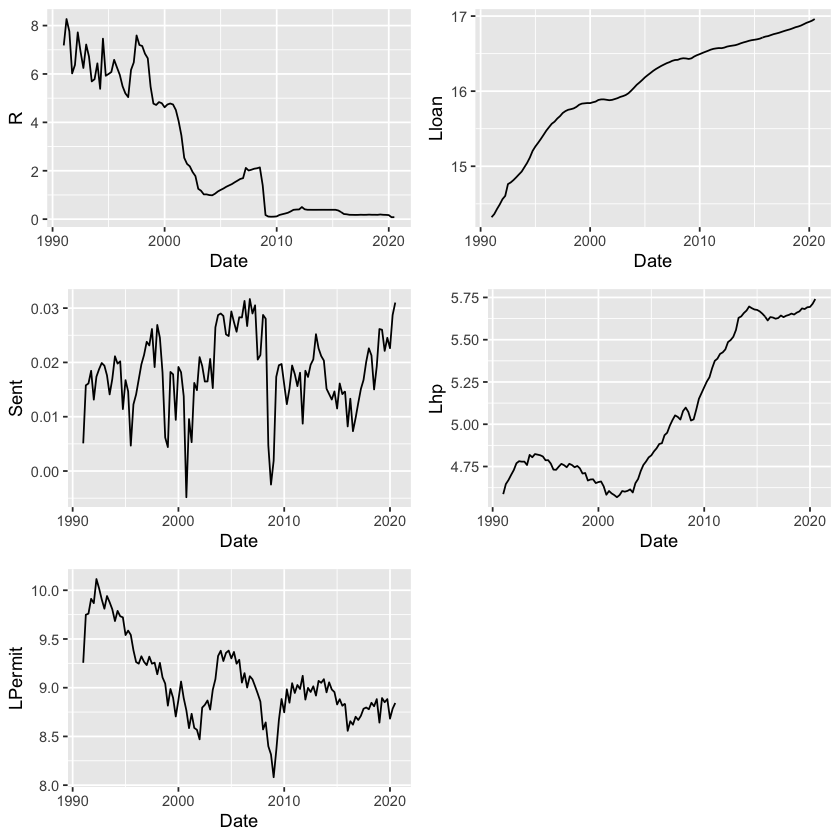

In [13]:
raw_level_R <- ggplot(data_new, aes(x = Date, y = R))+
    geom_line()

raw_level_Sent <- ggplot(data_new, aes(x = Date, y = Sent))+
    geom_line()

raw_level_LPermit <- ggplot(data_new, aes(x = Date, y = LPermit))+
    geom_line()

raw_level_dLloan <- ggplot(data_new, aes(x = Date, y = Lloan))+
    geom_line()

raw_level_dLhp <- ggplot(data_new, aes(x = Date, y = Lhp))+
    geom_line()

multiplot(raw_level_R, raw_level_Sent,
          raw_level_LPermit, raw_level_dLloan,
          raw_level_dLhp,
          cols = 2)

In [14]:
save_png(filename = "raw_new.png",
         plot = multiplot(raw_level_R, raw_level_Sent,
                        raw_level_LPermit, raw_level_dLloan,
                        raw_level_dLhp,
                        cols = 2))

pdf 
  2

### 模型設定

In [15]:
#----- 模型設定 -----#
VAR.P = 10                      # 最大的落後項數
CONST = TRUE                    # 是否有常數項
Y     = VAR.Y(By, VAR.P)        # 設定 Y
X     = VAR.X(By, VAR.P)        # 設定 X

In [16]:
hrz=19 # the length of response
shock_sign = -1 # control the positive/negative shock

## Reduced Form VAR

In [17]:
###### 參數估計 ######
(Coef.OLS    = VAR.OLS(Y, X, CONST)                  )
(Sigma.OLS   = VAR.Sigma.OLS(Y, X, Coef.OLS, CONST)  )
(Sigma.MLE   = VAR.Sigma.MLE(Y, X, Coef.OLS, CONST))

[,1]          [,2]       [,3]         [,4]         [,5]       
[1,]  0.9066537600 21.0113590  0.321506049 -4.588089266 -1.24612954
[2,] -0.0071957360  0.7258236  0.006474156  0.006327055 -0.04817076
[3,] -0.0084198677  7.9779430  0.460838337  2.736255594  0.98030945
[4,] -0.0007806428  0.2655568  0.009513847  1.628062884  0.02389986
[5,] -0.0087199954  0.9602059 -0.007207110  0.271213924  0.96363843
     [,6]         [,7]           [,8]         [,9]       [,10]        [,11]
[1,]  0.031911032 -3.81146915528 -0.180477468 19.0270911  3.104032811 ⋯    
[2,]  0.002774136  0.00002754776  0.007875716 -0.1372675  0.008547925 ⋯    
[3,] -0.120375961 -3.10079752178  0.392837397 -4.1668545 -0.424574114 ⋯    
[4,] -0.005493855  0.23904732964 -0.002425772 -0.7150932 -0.121849013 ⋯    
[5,] -0.012492667 -0.46395531524  0.016578366 -0.3966943 -0.025115316 ⋯    
     [,12]       [,13]        [,14]        [,15]         [,16]        
[1,]  1.33329778  0.178231872 -23.73736768 -4.1926911073  0.3953979843
[2,]  0.04638975  0.003478614  -0.08519683 -0.0804599297  0.0021554908
[3,] -3.44674190 -0.010426075  -3.64865187  0.2809650779  0.0576940773
[4,]  0.13839364 -0.006297928  -0.07674803  0.0007355847  0.0076857068
[5,] -0.43122612  0.019153614  -0.12474475  0.0341111858 -0.0009850668
     [,17]        [,18]        [,19]       [,20]        [,21]      
[1,]  1.821718582  0.025756862  8.82573611  1.770060780 -33.2927772
[2,] -0.200506118  0.005348976 -0.04196739  0.055423697  -0.2646743
[3,] -1.933274913 -0.044019749  1.99125851  0.001323652   2.7777108
[4,]  0.176728713  0.002015711  0.03040089  0.017532835   0.4834864
[5,]  0.003036048  0.003049466 -0.05128139 -0.036840516   0.3378596

[,1]          [,2]            [,3]          [,4]            [,5]          
[1,]  0.0660156298  0.000319309480 0.00050140358  0.000145606202 -0.00035890312
[2,]  0.0003193095  0.000027988119 0.00014660292 -0.000004350855  0.00007577314
[3,]  0.0005014036  0.000146602922 0.00957560969  0.000061575444  0.00087836773
[4,]  0.0001456062 -0.000004350855 0.00006157544  0.000035535952 -0.00001349620
[5,] -0.0003589031  0.000075773142 0.00087836773 -0.000013496196  0.00052990431

[,1]           [,2]            [,3]          [,4]           
[1,]  0.03512758281  0.000169907797 0.00026680191  0.000077478529
[2,]  0.00016990780  0.000014892761 0.00007800889 -0.000002315134
[3,]  0.00026680191  0.000078008894 0.00509527855  0.000032764915
[4,]  0.00007747853 -0.000002315134 0.00003276492  0.000018909039
[5,] -0.00019097597  0.000040319653 0.00046738833 -0.000007181462
     [,5]           
[1,] -0.000190975975
[2,]  0.000040319653
[3,]  0.000467388335
[4,] -0.000007181462
[5,]  0.000281967429

### 選擇lag期數

In [18]:
# 依據AIC選擇
VAR.P = 10

# SVAR

## Identification

In [19]:
### 4-variable model

Amat = diag(5)
# Identification Conditions

Amat[2,1]  = NA; 
Amat[3,1]  = NA; Amat[3,2]  = NA;
Amat[4,1]  = NA; Amat[4,2]  = NA; Amat[4,3]  = NA;
Amat[5,1]  = NA; Amat[5,2]  = NA; Amat[5,3]  = NA; Amat[5,4]  = NA;

Bmat = diag(5)
diag(Bmat) = NA

Amat;Bmat

[,1] [,2] [,3] [,4] [,5]
[1,]  1    0    0    0   0   
[2,] NA    1    0    0   0   
[3,] NA   NA    1    0   0   
[4,] NA   NA   NA    1   0   
[5,] NA   NA   NA   NA   1

[,1] [,2] [,3] [,4] [,5]
[1,] NA    0    0    0    0  
[2,]  0   NA    0    0    0  
[3,]  0    0   NA    0    0  
[4,]  0    0    0   NA    0  
[5,]  0    0    0    0   NA

## 估計 $\hat{A} , \hat{B}$

* Recall 模型設定:

$$D(L)Y_t = Be_t$$

可以推得:

$$Y_t = \Phi_1 Y_{t-1} + \dots + \Phi_p Y_{t-p} + \varepsilon_t $$

1. 為 $A, B$ matrix 加上 zero constraints

2. 從$\Sigma_\varepsilon = CC'$知道 cholesky decomposition的 $C = (I-D_0)^{-1}B = A^{-1}B$ 

In [20]:
C.Prime <- chol(Sigma.OLS)

In [21]:
C <- t(C.Prime)
C

[,1]          [,2]          [,3]         [,4]          [,5]      
[1,]  0.2569350692  0.0000000000 0.0000000000  0.0000000000 0.00000000
[2,]  0.0012427633  0.0051423398 0.0000000000  0.0000000000 0.00000000
[3,]  0.0019514797  0.0280373720 0.0937321033  0.0000000000 0.00000000
[4,]  0.0005667043 -0.0009830417 0.0009391813  0.0057763627 0.00000000
[5,] -0.0013968631  0.0150727324 0.0048915351 -0.0004295958 0.01663292

令 

$$
A = \left[
\begin{array}{ccccc}
1 &0 &0 &0 &0\\
a_{21} &1 &0 &0 &0\\
a_{31} &a_{32} &1 &0 &0\\
a_{41} &a_{42} &a_{43} &1 &0\\
a_{41} &a_{42} &a_{43} &a_{44} &1\\
\end{array}
\right]
$$

$$
B = \left[
\begin{array}{ccccc}
\sigma_1 &0 &0 &0 &0\\
0 &\sigma_2 &0 &0 &0\\
0 &0 &\sigma_3 &0 &0\\
0 &0 &0 &\sigma_4 &0\\
0 &0 &0 &0 &\sigma_5\\
\end{array}
\right]
$$

### Note: Solving system of linear equations

由於 $B, C$已知，又$AC = B$，故$A = BC^{-1}$

In [22]:
B0 <- diag(diag(C), ncol = 5, nrow = 5)
B0

[,1]      [,2]       [,3]      [,4]        [,5]      
[1,] 0.2569351 0.00000000 0.0000000 0.000000000 0.00000000
[2,] 0.0000000 0.00514234 0.0000000 0.000000000 0.00000000
[3,] 0.0000000 0.00000000 0.0937321 0.000000000 0.00000000
[4,] 0.0000000 0.00000000 0.0000000 0.005776363 0.00000000
[5,] 0.0000000 0.00000000 0.0000000 0.000000000 0.01663292

In [23]:
A0 <- B0 %*% solve(C)
A0

[,1]         [,2]      [,3]                      
[1,]  1.000000000  0.000000  0.00000000000000000000000
[2,] -0.004836877  1.000000 -0.00000000000000004072524
[3,]  0.018776684 -5.452260  1.00000000000000022204460
[4,] -0.003318419  0.245797 -0.01001984664642319687589
[5,]  0.018387346 -2.628290 -0.05293152662822461079761
     [,4]                        [,5]                     
[1,]  0.000000000000000000000000  0.0000000000000000000000
[2,]  0.000000000000000005243687  0.0000000000000000419495
[3,] -0.000000000000000028589945 -0.0000000000000002287196
[4,]  1.000000000000000000000000  0.0000000000000000000000
[5,]  0.074371339902086150419613  0.9999999999999998889777

In [24]:
SVAR_AB_est <- list("A0.svar" = A0, "B0.svar" = B0)

## IRF (without Bootstrap C.I.)

In [25]:
### IRF
SVAR_AB_IRF <- VAR.svarirf.AB(By, VAR.P, Amat, Bmat, h = hrz, CONST, SVAR_AB_est = SVAR_AB_est)


# 5*5個圖的time series
df_IRF_plot <- matrix(NA, hrz+1, 25) #%>% as.tibble() ## hrz+1
#dim(df_IRF_plot)
h <- 0 # h表示第幾期的IRF
for(period in SVAR_AB_IRF){
  k <- 0 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
  h <- h+1 # h表示第幾期的IRF
  for(j in 1:5){
    for(i in 1:5){
      k <- k+1 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
      df_IRF_plot[h,k] <- period[i,j]
    }
  }
}
df_IRF_plot <- df_IRF_plot %>% as_tibble()

In [26]:
#output entire table
IRF_TABLE <- df_IRF_plot[,c(5,10,15,20,25)] %>% select(mp=1,exp=2,hs=3,hd=4,hp=5)
write.table(IRF_TABLE, file = "result/table/IRF_TABLE.csv", sep = ",", row.names = FALSE)

In [27]:
p1 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V1))
p2 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V2))
p3 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V3))
p4 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V4))
p5 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V5))
p6 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V6))
p7 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V7))
p8 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V8))
p9 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V9))
p10 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V10))
p11 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V11))
p12 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V12))
p13 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V13))
p14 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V14))
p15 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V15))
p16 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V16))
p17 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V17))
p18 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V18))
p19 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V19))
p20 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V20))
p21 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V21))
p22 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V22))
p23 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V23))
p24 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V24))
p25 <- ggplot(df_IRF_plot) + geom_line(aes(x = 1:nrow(df_IRF_plot), y = V25))

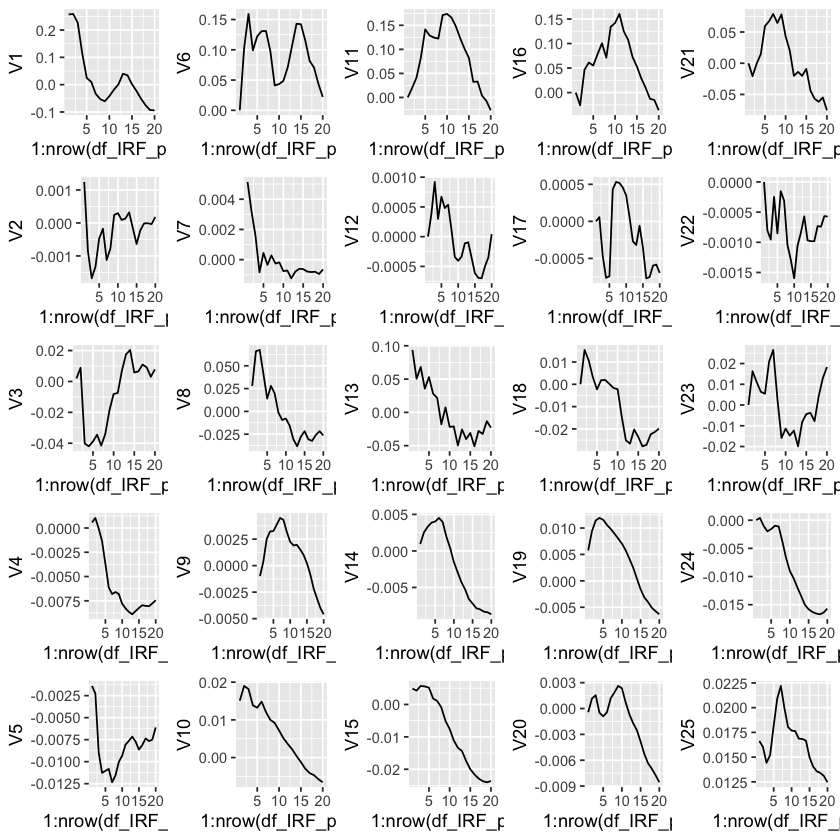

In [28]:
multiplot(p1,p2,p3,p4,p5,
          p6,p7,p8,p9,p10,
          p11,p12,p13,p14,p15,
          p16,p17,p18,p19,p20,
          p21,p22,p23,p24,p25,
          cols = 5)

## IRF (Bootstrap C.I.)

Steps:

1. 從殘差取後放回重抽T個

2. 從估計值加上重抽的T個殘差，得到5條 period為T的pseudo time series

3. 從pseudo time series再估SVAR及IRF

    a. 估的時候要用重新估計的 $\hat{A}, \hat{B}$ matrix來計算IRF
    
    b. 估的條件相似，是當重抽一組residual並得到pseudo time series後，一樣要 $se(\hat{A}), se(\hat{B})$ 存在才算進一個bootstrap statistics
    
    c. 停止條件是蒐集到1000條

4. 從IRF的2.5% quantile跟97.5%quantile找到IRF的95% C.I.

存法：用arrary：

1. row數為總期間減去lag期數

2. column數為變數總數的平方（shock1對y1,..., shock5對y5）

3. page數為Bootstrap重複的次數

# Bootstrap C.I.

* Ref: http://www.eviews.com/help/helpintro.html#page/content%2Fmodels-Solving_the_Model.html%23ww100137

## Several Approaches:

1. 
    1. Resampling
    2. calculate the sd of each period of a given shock and response
    3. the C.I. is the IRF estimate +/- sd * z_{1-alpha/2}

2. 
    1. Resampling
    2. find the median and 2.5%, 97.5% quantiles to construct a 95% C.I.
    
## Consider
1. one sd shock
2. unit shock
3. negative sd shock
4. negative unit shock

## Resampling

In [29]:
#```R
lower = 0.025                                        # 控制成 95% CI
upper = 1-lower
kk = ncol(By)
ddY = VAR.ddY(By, VAR.P)
ddX = VAR.ddX(By, VAR.P)

# dim(ddY); dim(ddX)

T   = nrow(ddY)
T.total= nrow(By)
Ik  = diag(rep(1, kk))
# 16 coef if 4 variables; 55 coef if 5 variables
Coef = t(VAR.EbyE(ddY, ddX, CONST)$ddA)              # Step 1 估計模型
# residuals
U    = VAR.EbyE(ddY, ddX, CONST)$ddU
BSigma.u = VAR.ddSigma.OLS(ddY, ddX, CONST)
if(CONST == TRUE){
  const = Coef[, ncol(Coef)]
  Coef.noc= Coef[,-ncol(Coef)]                      # 刪掉 const
}else{
  const = matrix(0, kk, 1)
  Coef.noc = Coef
}

Theta.unit= VAR.Theta(Coef, h, BSigma.u, CONST)$unit # 估算 Theta.unit
Theta.std = VAR.Theta(Coef, h, BSigma.u, CONST)$std  # 估算 Theta.std

# dm.U <- U-mean(U)
dm.U <- U

N = 2000 #重抽次數
Theta.unit.sim = vector("list", N)
Theta.std.sim  = vector("list", N)

# check dimension
print("check dimensionality")
dim(ddX); dim(Coef.noc); dim(dm.U)


# 存N次重抽的IRF
df_IRF.sim <- array(NA, c(hrz+1,kk^2,N)) #dimensions are: Time Period, Number of shock interacts with variables, page (number of Bootstrap resamplings)
counter <- 1
while(TRUE){

  #cat("Now, there are ", counter-1, " sets of resamples.\n")
  Y.sim = matrix(0, nrow = T.total, ncol = kk)          # Y.sim = 0 #pseudo time series
  Y.sim[c(1:VAR.P),] = By[c(1:VAR.P), ] #initial values

  boot.number = sample(c(1:T), replace = TRUE)      # Step 3 取出放回
  U.sim = dm.U[boot.number,]

    # predicted values given the above initial values
    last.y= c(t(By[VAR.P:1,]))
    for(ii in 1:T){
         last.y = last.y[1:(kk*VAR.P)]
         Y.sim[ii+VAR.P, ] = Coef.noc %*% last.y + const + U.sim[ii,]      # Step 4 模擬資料
         last.y = c(Y.sim[ii+VAR.P,], last.y)
      }
  
#   Y.sim[-c(1:VAR.P),] <- matrix(const, nrow = T.total-VAR.P, ncol = kk, byrow = T) + ddX %*% t(Coef.noc) + U.sim
  
    
  #`Y.sim` is the pseudo time series
  # Step 5 重新估算SVAR
  
  ### SVAR.sim Start ###

    Y_pseudo     = VAR.Y(Y.sim, VAR.P)        # 設定 Y
    X_pseudo     = VAR.X(Y.sim, VAR.P)        # 設定 X
    Coef.OLS_pseudo    = VAR.OLS(Y_pseudo, X_pseudo, CONST)
    Sigma.OLS_pseudo   = VAR.Sigma.OLS(Y_pseudo, X_pseudo, Coef.OLS_pseudo, CONST)
    C.Prime_pseudo <- chol(Sigma.OLS_pseudo)
    C_pseudo <- t(C.Prime_pseudo)
    B0_pseudo <- diag(diag(C_pseudo), ncol = 5, nrow = 5)
    A0_pseudo <- B0_pseudo %*% solve(C_pseudo)
    SVAR_AB_est.sim <- list("A0.svar" = A0_pseudo, "B0.svar" = B0_pseudo)
    SVAR_AB_IRF.sim <- VAR.svarirf.AB(Y.sim, VAR.P, Amat, Bmat, h = hrz, CONST, SVAR_AB_est = SVAR_AB_est.sim)
    
  # 5*5個圖的time series
  df_IRF_plot.sim <- matrix(NA, hrz+1, kk^2) #%>% as.tibble()
  # df_IRF.sim <- array(1:(120*25*N), c(120,25,N))
  # df_IRF.sim[2,1,1] # slicing
  
  h <- 0 # h表示第幾期的IRF
  for(period in SVAR_AB_IRF.sim){
    k <- 0 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
    h <- h+1 # h表示第幾期的IRF
    for(j in 1:kk){
      for(i in 1:kk){
        k <- k+1 # k表示把5*5的矩陣攤平到25個col的df時，要攤到第幾個columns上
        df_IRF_plot.sim[h,k] <- period[i,j]
      }
    }
  }
  # 把這一次重抽得到的IRF append進`df_IRF.sim`中
  df_IRF.sim[,,counter] <- df_IRF_plot.sim
  ### SVAR.sim Ends ###
  if(counter>=N){
    break
  }
  counter <- counter+1
}
#```

[1] "check dimensionality"


[1] 109  50

[1]  5 50

[1] 109   5

In [30]:
#```R
# Save
saveRDS(df_IRF.sim, file = "df_IRF.sim_2021-11-08_m1_hrz20.rds")
#```

In [31]:
df_IRF.sim <- read_rds("df_IRF.sim_2021-11-08_m1_hrz20.rds")

In [32]:
# 看某一頁
head(df_IRF.sim[,,1000])
print(sum(is.na(df_IRF.sim)))

[,1]       [,2]          [,3]         [,4]          [,5]        
[1,] 0.21118490  0.0004757010  0.002601979  0.0005141214 -0.001375875
[2,] 0.20020074 -0.0022487391  0.010432738  0.0017973395 -0.006493703
[3,] 0.16652826 -0.0019943460 -0.034898200  0.0003725510 -0.012536266
[4,] 0.08030688 -0.0007944912 -0.031073893 -0.0013396516 -0.012121310
[5,] 0.02232610  0.0001194099 -0.019465937 -0.0039850341 -0.010131704
[6,] 0.01429090  0.0003253116 -0.009559758 -0.0062956822 -0.008052948
     [,6]       [,7]          [,8]        [,9]          [,10]       [,11]
[1,] 0.00000000  0.0032542688 0.024912708 -0.0008455908 0.009312501 ⋯    
[2,] 0.08445289  0.0024526231 0.050845868  0.0003977174 0.009603131 ⋯    
[3,] 0.12137993  0.0018643573 0.052484680  0.0027803364 0.010875106 ⋯    
[4,] 0.11087873  0.0003144328 0.042511721  0.0053193674 0.010626424 ⋯    
[5,] 0.12162888 -0.0003904005 0.014171071  0.0065565463 0.006952022 ⋯    
[6,] 0.10308204 -0.0008983404 0.005669104  0.0061540714 0.003980459 ⋯    
     [,12]       [,13]                          [,14]                       
[1,]  0.00000000 -0.000000000000000000009023658 -0.0000000000000000001605812
[2,] -0.01441795 -0.000158120151437281562323625  0.0132294347791350498655394
[3,]  0.04827929 -0.001122343754954936495202289  0.0039233926173199611467379
[4,]  0.04378172 -0.001277292628952714963544435 -0.0105468103543532986526854
[5,]  0.02897047 -0.000731048567082008397301218 -0.0271023815313721737341179
[6,]  0.03322650 -0.000052854864481096156501871 -0.0201751781069955289649176
     [,15]       [,16]         [,17]       [,18]                       
[1,] 0.004300779 -0.0002689006  0.00000000 -0.0000000000000000004760659
[2,] 0.006769500  0.0029062843 -0.02088286 -0.0015185842509887418488868
[3,] 0.008315200  0.0001666146 -0.01252713 -0.0005352540859846931968827
[4,] 0.007705539 -0.0041568576 -0.01402313  0.0000395519405115992529276
[5,] 0.005768583 -0.0056821241 -0.01625057 -0.0004406533260638071367900
[6,] 0.003894465 -0.0044545922 -0.06552008  0.0002946030729033011783327
     [,19]                        [,20]                        [,21]      
[1,]  0.0000000000000000000250317  0.0000000000000000001488053 0.010783775
[2,] -0.0083744282953249135625917  0.0004563384046156519985651 0.005374617
[3,]  0.0005159513543773777645082 -0.0012805794450227421868438 0.003439942
[4,] -0.0208398828227328788975647 -0.0024716801617808903043794 0.003545911
[5,] -0.0090137262236886731697760 -0.0023127894071255754304683 0.004633187
[6,]  0.0006939630411367687110383 -0.0025559397038753912598241 0.006769772

[1] 0


## Find C.I. through bootstrap SD

In [34]:
dim(df_IRF.sim)
df_bootstrap_SD <- matrix(NA, nrow = 20, ncol = 25)
for(row in 1:20){
    for(col in 1:25){
        df_bootstrap_SD[row, col] <- sd(df_IRF.sim[row,col,])
    }
}

[1]   20   25 2000

In [35]:
df_IRF_plot %>% dim()
df_bootstrap_SD %>% dim()

[1] 20 25

[1] 20 25

In [36]:
alpha = 0.05
quantile_z <- qnorm(1-alpha/2)
quantile_z

[1] 1.959964

In [37]:
# df_IRF_plot: point estimate
df_IRF_plot.BS <- df_IRF_plot

# upper bound (95% C.I.)
df_IRF_plot.BS.U <- df_IRF_plot + df_bootstrap_SD*quantile_z

# lower bound (95% C.I.)
df_IRF_plot.BS.L <- df_IRF_plot - df_bootstrap_SD*quantile_z

In [38]:
# lot
ind <- 0
for(i in 1:5){
  for(j in 1:5){
    ind <- ind+1
    nam <- paste("shock", j, "y", i, sep = '')
    assign(nam, bind_cols(df_IRF_plot.BS.L[ind], df_IRF_plot.BS.U[ind],
                          df_IRF_plot[ind]))
    # 改名
    evalStr <- paste0("colnames(", nam, ") <- c('Lower', 'Upper', 'Actual')")
    eval(parse(text=evalStr))
    # 圖層
    evalStr <- paste0("p", ind, " <- ", "ggplot(",nam,") +geom_hline(yintercept=0, color = 'grey')+ geom_line(aes(x = 1:nrow(", nam, "), y = Lower), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Upper), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Actual), col = 'Blue')")
    eval(parse(text=evalStr))
  }
}

New names:
* V1 -> V1...1
* V1 -> V1...2
* V1 -> V1...3

New names:
* V2 -> V2...1
* V2 -> V2...2
* V2 -> V2...3

New names:
* V3 -> V3...1
* V3 -> V3...2
* V3 -> V3...3

New names:
* V4 -> V4...1
* V4 -> V4...2
* V4 -> V4...3

New names:
* V5 -> V5...1
* V5 -> V5...2
* V5 -> V5...3

New names:
* V6 -> V6...1
* V6 -> V6...2
* V6 -> V6...3

New names:
* V7 -> V7...1
* V7 -> V7...2
* V7 -> V7...3

New names:
* V8 -> V8...1
* V8 -> V8...2
* V8 -> V8...3

New names:
* V9 -> V9...1
* V9 -> V9...2
* V9 -> V9...3

New names:
* V10 -> V10...1
* V10 -> V10...2
* V10 -> V10...3

New names:
* V11 -> V11...1
* V11 -> V11...2
* V11 -> V11...3

New names:
* V12 -> V12...1
* V12 -> V12...2
* V12 -> V12...3

New names:
* V13 -> V13...1
* V13 -> V13...2
* V13 -> V13...3

New names:
* V14 -> V14...1
* V14 -> V14...2
* V14 -> V14...3

New names:
* V15 -> V15...1
* V15 -> V15...2
* V15 -> V15...3

New names:
* V16 -> V16...1
* V16 -> V16...2
* V16 -> V16...3

New names:
* V17 -> V17...1
* V17 -> V17...2
*

In [39]:
Text_Size_Theme = theme(
  axis.title.x = element_text(size = 12),
  axis.text.x = element_text(size = 12),
  axis.title.y = element_text(size = 12),
  axis.title = element_text(size = 12),
  plot.title = element_text(size=12))

## shock1: mp
p1 <- p1+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Monetary Policy Shock')+Text_Size_Theme
p2 <- p2+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Monetary Policy Shock')+Text_Size_Theme
p3 <- p3+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Monetary Policy Shock')+Text_Size_Theme
p4 <- p4+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Monetary Policy Shock')+Text_Size_Theme
p5 <- p5+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Monetary Policy Shock')+Text_Size_Theme

## shock2: exp
p6 <- p6+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Expectation Shock')+Text_Size_Theme
p7 <- p7+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Expectation Shock')+Text_Size_Theme
p8 <- p8+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Expectation Shock')+Text_Size_Theme
p9 <- p9+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Housing Expectation Shock')+Text_Size_Theme
p10 <- p10+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Expectation Shock')+Text_Size_Theme

## shock3: supply
p11 <- p11+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Supply Shock')+Text_Size_Theme
p12 <- p12+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Supply Shock')+Text_Size_Theme
p13 <- p13+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Supply Shock')+Text_Size_Theme
p14 <- p14+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Housing Supply Shock')+Text_Size_Theme
p15 <- p15+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Supply Shock')+Text_Size_Theme




## shock4: demand
p16 <- p16+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Demand Shock')+Text_Size_Theme
p17 <- p17+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Demand Shock')+Text_Size_Theme
p18 <- p18+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Demand Shock')+Text_Size_Theme
p19 <- p19+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Housing Demand Shock')+Text_Size_Theme
p20 <- p20+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Demand Shock')+Text_Size_Theme



## shock5: sp
p21 <- p21+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Residual Shock')+Text_Size_Theme
p22 <- p22+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Residual Shock')+Text_Size_Theme
p23 <- p23+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Residual Shock')+Text_Size_Theme
p24 <- p24+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Residual Shock')+Text_Size_Theme
p25 <- p25+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Residual Shock')+Text_Size_Theme

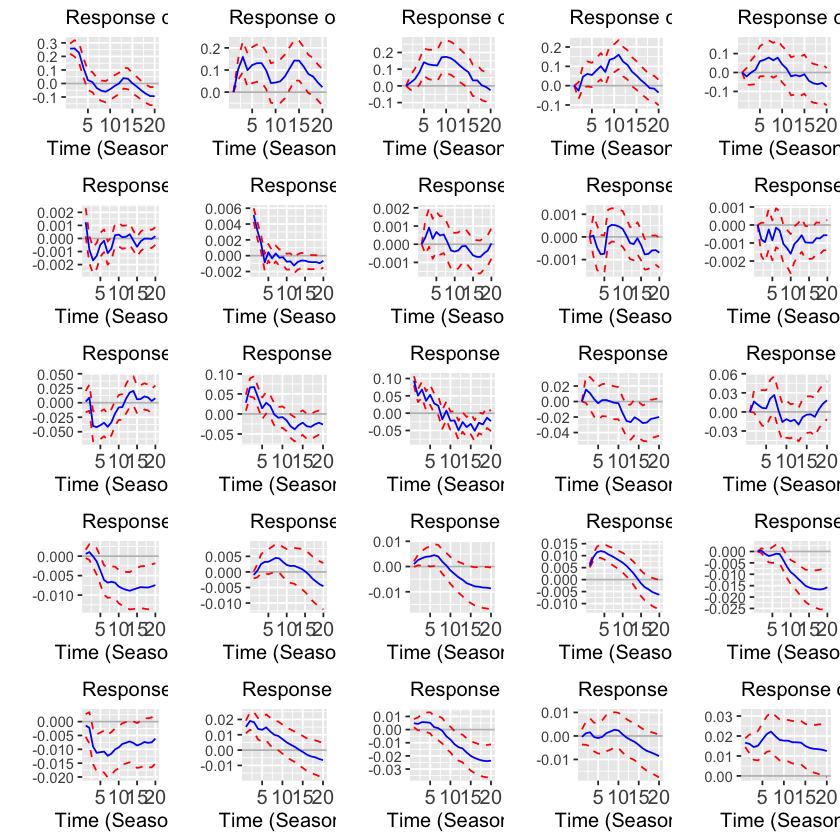

pdf 
  2

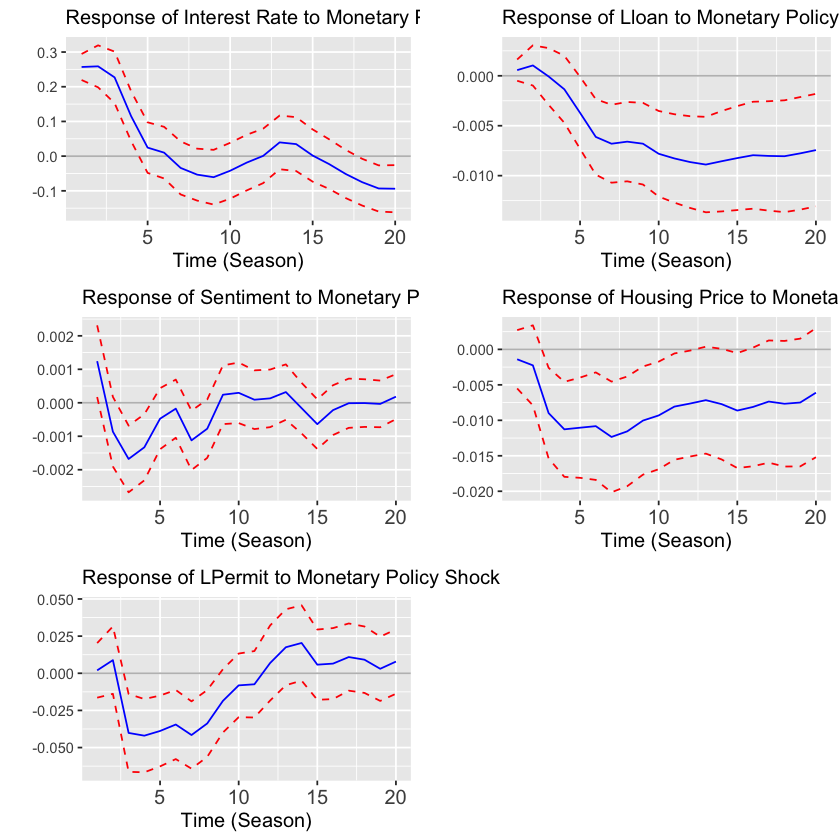

pdf 
  2

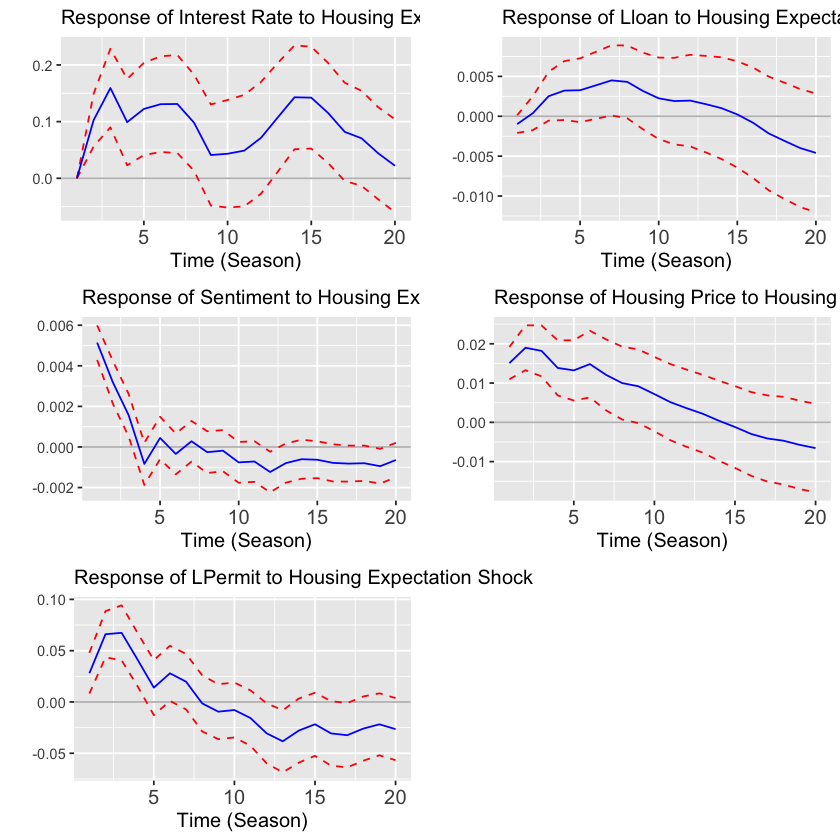

pdf 
  2

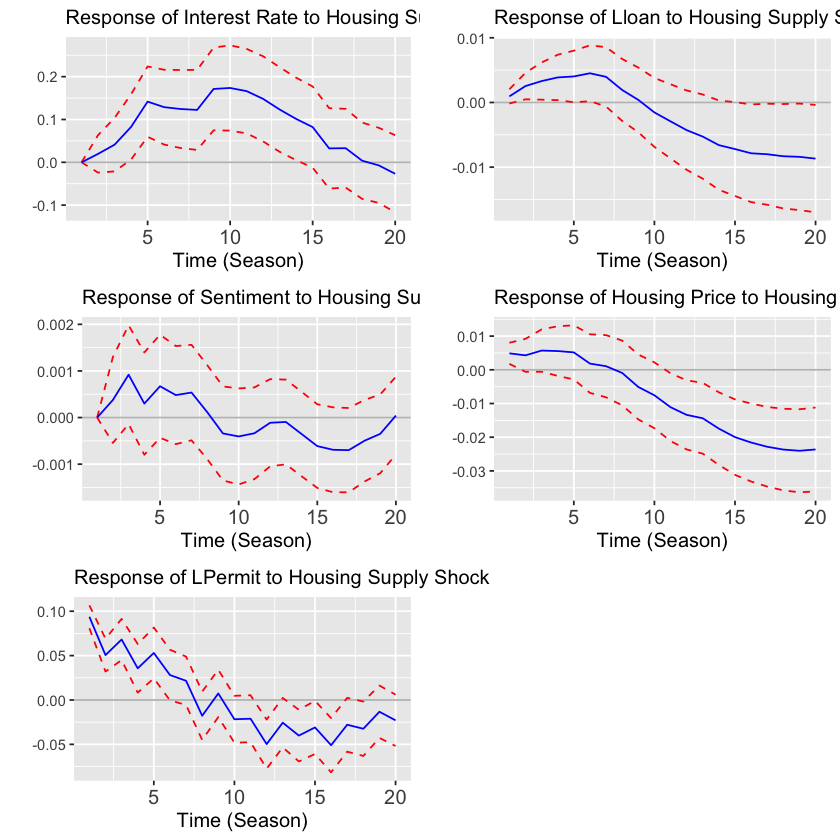

pdf 
  2

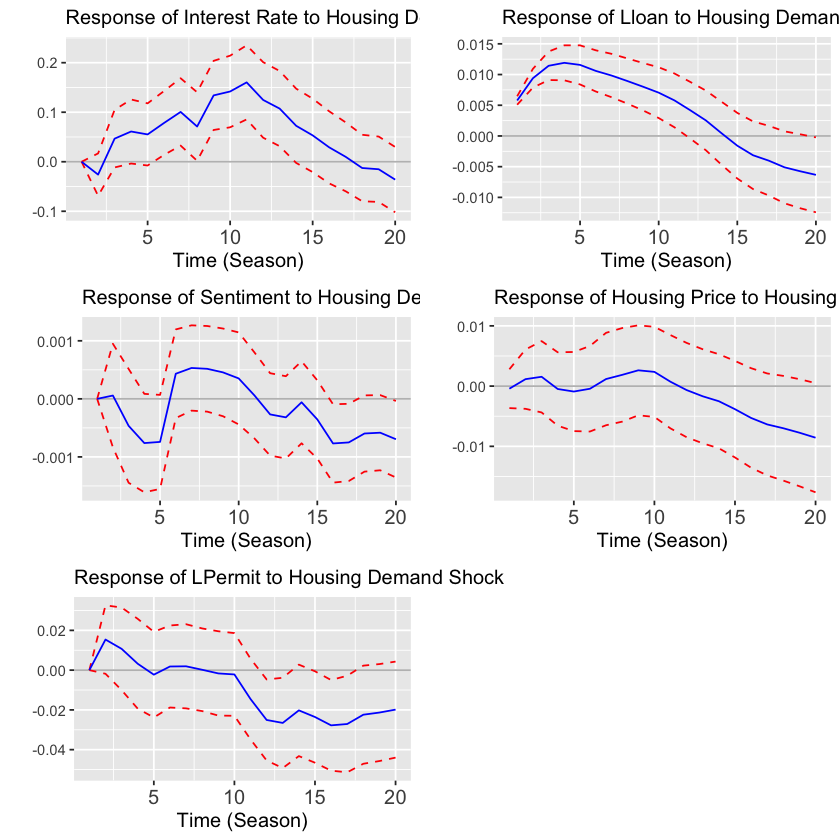

pdf 
  2

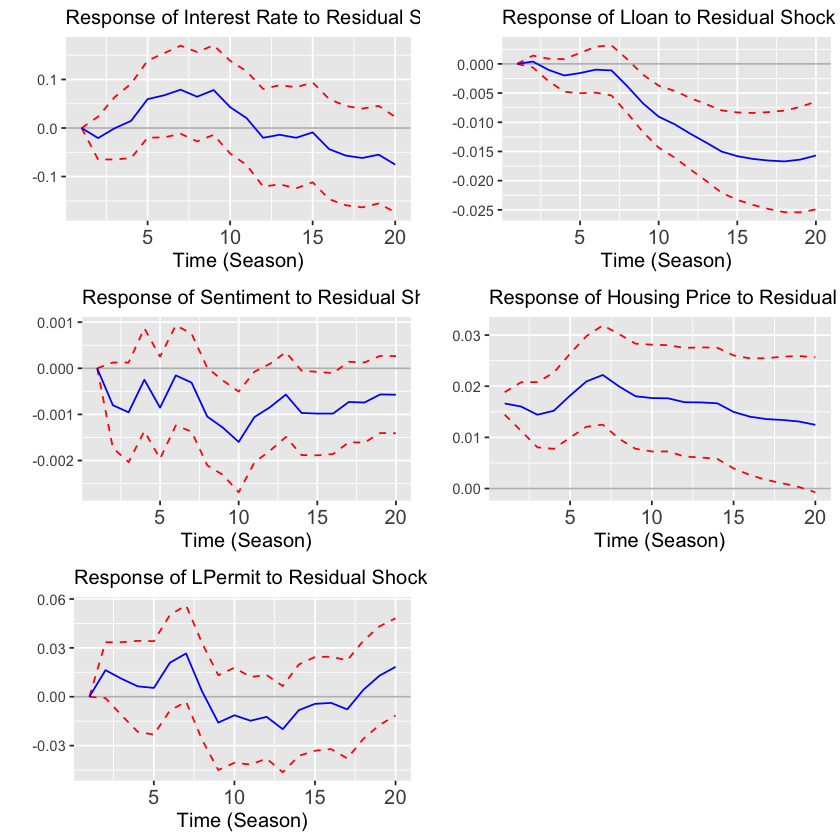

In [40]:
multiplot(p1,p2,p3,p4,p5,
          p6,p7,p8,p9,p10,
          p11,p12,p13,p14,p15,
          p16,p17,p18,p19,p20,
          p21,p22,p23,p24,p25,
          cols = 5)
# For shock 1
multiplot(p1,p2,p3,p4,p5,
          cols = 2)
save_png(filename = "result/figure/IRF_sd_shock1.png",
         plot = multiplot(p1,p2,p3,p4,p5,
                          cols = 2)
        )
# For shock 2
multiplot(p6,p7,p8,p9,p10,
          cols = 2)
save_png(filename = "result/figure/IRF_sd_shock2.png",
         plot = multiplot(p6,p7,p8,p9,p10,
                          cols = 2)
        )
# For shock 3
multiplot(p11,p12,p13,p14,p15,
          cols = 2)
save_png(filename = "result/figure/IRF_sd_shock3.png",
         plot = multiplot(p11,p12,p13,p14,p15,
                          cols = 2)
        )
# For shock 4
multiplot(p16,p17,p18,p19,p20,
          cols = 2)
save_png(filename = "result/figure/IRF_sd_shock4.png",
         plot = multiplot(p16,p17,p18,p19,p20,
                          cols = 2)
        )
# For shock 5
multiplot(p21,p22,p23,p24,p25,
          cols = 2)
save_png(filename = "result/figure/IRF_sd_shock5.png",
         plot = multiplot(p21,p22,p23,p24,p25,
                          cols = 2)
        )

### 考量shock sign (still using bootstrap sd)

In [42]:
df_IRF_plot.BS.L_negative <- (df_IRF_plot.BS.L*shock_sign) %>% as_tibble()
df_IRF_plot.BS.U_negative <- (df_IRF_plot.BS.U*shock_sign) %>% as_tibble()
# df_IRF_plot.BS.Median_negative <- (df_IRF_plot.BS.Median*shock_sign) %>% as_tibble()
# df_IRF_plot.BS.Mean_negative <- (df_IRF_plot.BS.Mean*shock_sign) %>% as_tibble()
df_IRF_plot_negative <- (df_IRF_plot*shock_sign) %>% as_tibble()

ind <- 0
for(i in 1:5){
  for(j in 1:5){
    ind <- ind+1
    nam <- paste("shock", j, "y", i,"_negative", sep = '')
    assign(nam, bind_cols(df_IRF_plot.BS.L_negative[ind], df_IRF_plot.BS.U_negative[ind],
                          df_IRF_plot_negative[ind]))
    # 改名
    evalStr <- paste0("colnames(", nam, ") <- c('Lower', 'Upper', 'Actual')")
    eval(parse(text=evalStr))
    # 圖層
    evalStr <- paste0("p", ind, " <- ", "ggplot(",nam,") +geom_hline(yintercept=0, color = 'grey')+ geom_line(aes(x = 1:nrow(", nam, "), y = Lower), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Upper), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Actual), col = 'Blue')")
    eval(parse(text=evalStr))
  }
}

New names:
* V1 -> V1...1
* V1 -> V1...2
* V1 -> V1...3

New names:
* V2 -> V2...1
* V2 -> V2...2
* V2 -> V2...3

New names:
* V3 -> V3...1
* V3 -> V3...2
* V3 -> V3...3

New names:
* V4 -> V4...1
* V4 -> V4...2
* V4 -> V4...3

New names:
* V5 -> V5...1
* V5 -> V5...2
* V5 -> V5...3

New names:
* V6 -> V6...1
* V6 -> V6...2
* V6 -> V6...3

New names:
* V7 -> V7...1
* V7 -> V7...2
* V7 -> V7...3

New names:
* V8 -> V8...1
* V8 -> V8...2
* V8 -> V8...3

New names:
* V9 -> V9...1
* V9 -> V9...2
* V9 -> V9...3

New names:
* V10 -> V10...1
* V10 -> V10...2
* V10 -> V10...3

New names:
* V11 -> V11...1
* V11 -> V11...2
* V11 -> V11...3

New names:
* V12 -> V12...1
* V12 -> V12...2
* V12 -> V12...3

New names:
* V13 -> V13...1
* V13 -> V13...2
* V13 -> V13...3

New names:
* V14 -> V14...1
* V14 -> V14...2
* V14 -> V14...3

New names:
* V15 -> V15...1
* V15 -> V15...2
* V15 -> V15...3

New names:
* V16 -> V16...1
* V16 -> V16...2
* V16 -> V16...3

New names:
* V17 -> V17...1
* V17 -> V17...2
*

In [43]:
## shock1: mp
p1 <- p1+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Monetary Policy Shock')+Text_Size_Theme
p2 <- p2+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Monetary Policy Shock')+Text_Size_Theme
p3 <- p3+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Monetary Policy Shock')+Text_Size_Theme
p4 <- p4+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Monetary Policy Shock')+Text_Size_Theme
p5 <- p5+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Monetary Policy Shock')+Text_Size_Theme

## shock2: exp
p6 <- p6+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Expectation Shock')+Text_Size_Theme
p7 <- p7+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Expectation Shock')+Text_Size_Theme
p8 <- p8+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Expectation Shock')+Text_Size_Theme
p9 <- p9+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Housing Expectation Shock')+Text_Size_Theme
p10 <- p10+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Expectation Shock')+Text_Size_Theme

## shock3: supply
p11 <- p11+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Supply Shock')+Text_Size_Theme
p12 <- p12+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Supply Shock')+Text_Size_Theme
p13 <- p13+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Supply Shock')+Text_Size_Theme
p14 <- p14+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Housing Supply Shock')+Text_Size_Theme
p15 <- p15+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Supply Shock')+Text_Size_Theme




## shock4: demand
p16 <- p16+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Demand Shock')+Text_Size_Theme
p17 <- p17+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Demand Shock')+Text_Size_Theme
p18 <- p18+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Demand Shock')+Text_Size_Theme
p19 <- p19+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Housing Demand Shock')+Text_Size_Theme
p20 <- p20+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Demand Shock')+Text_Size_Theme



## shock5: sp
p21 <- p21+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Residual Shock')+Text_Size_Theme
p22 <- p22+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Residual Shock')+Text_Size_Theme
p23 <- p23+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Residual Shock')+Text_Size_Theme
p24 <- p24+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Residual Shock')+Text_Size_Theme
p25 <- p25+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Residual Shock')+Text_Size_Theme

pdf 
  2

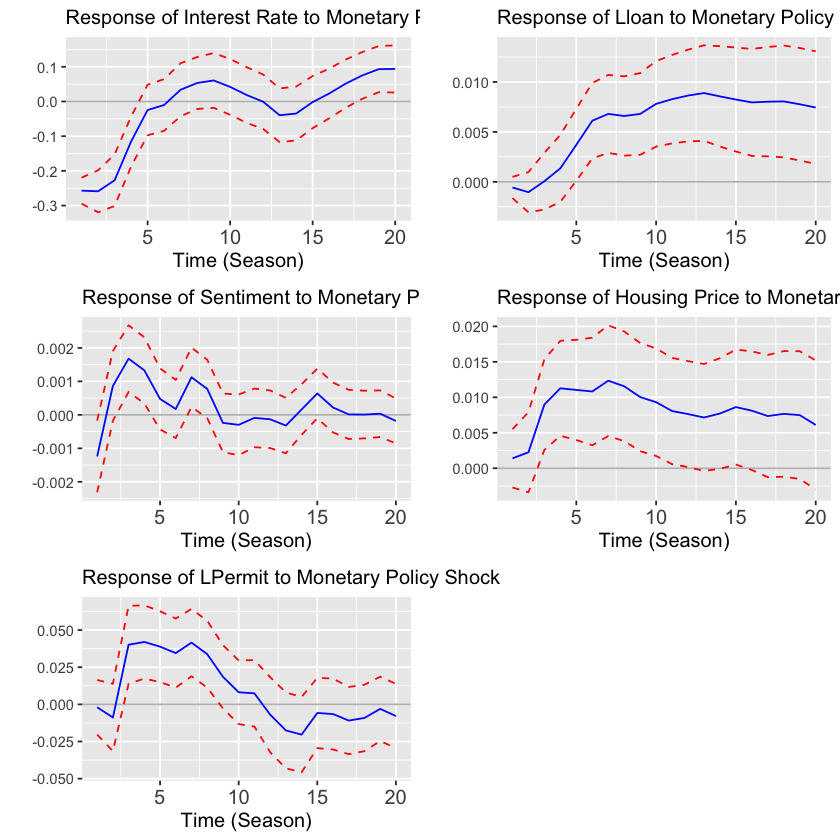

pdf 
  2

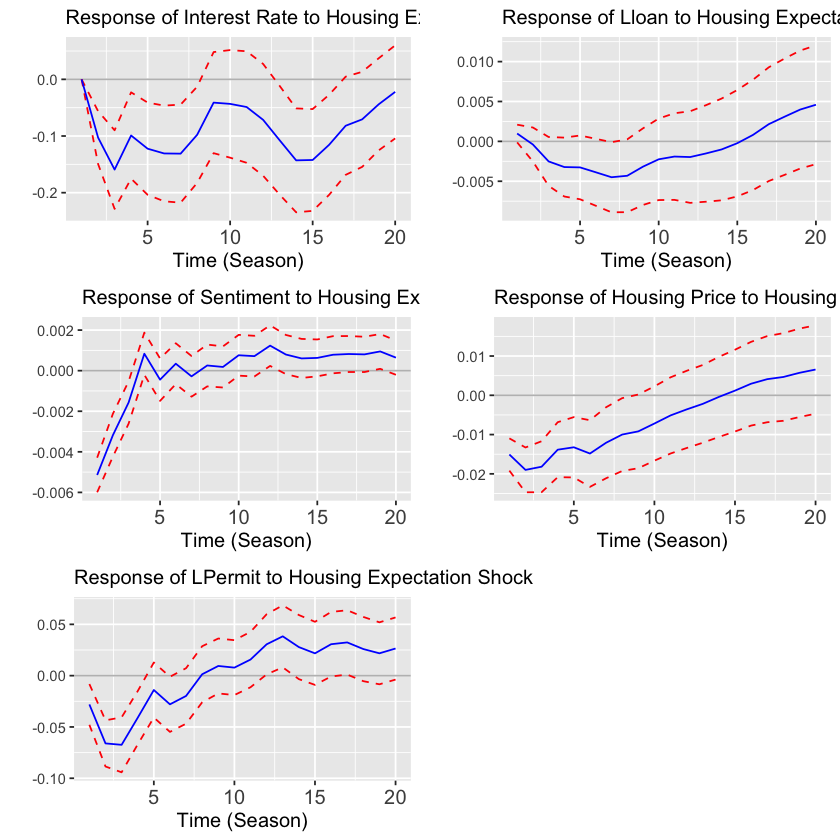

pdf 
  2

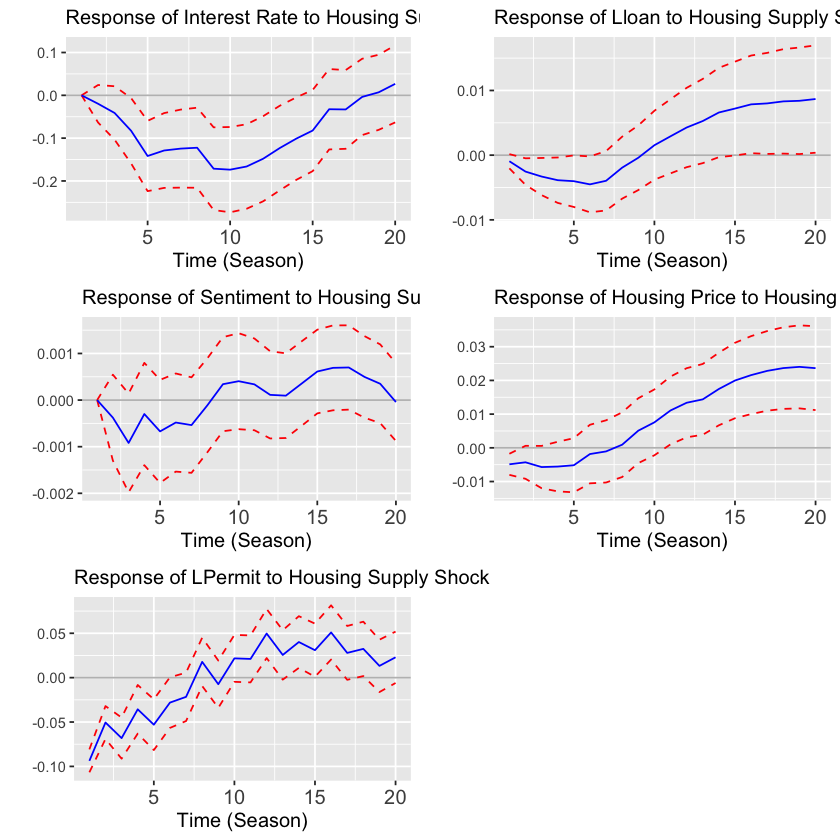

pdf 
  2

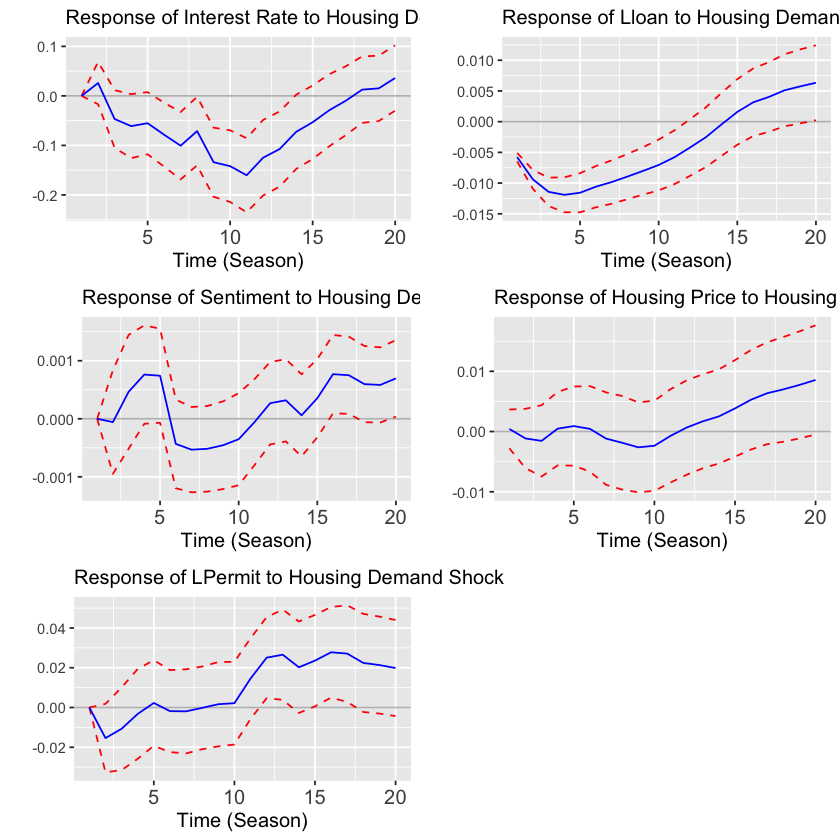

pdf 
  2

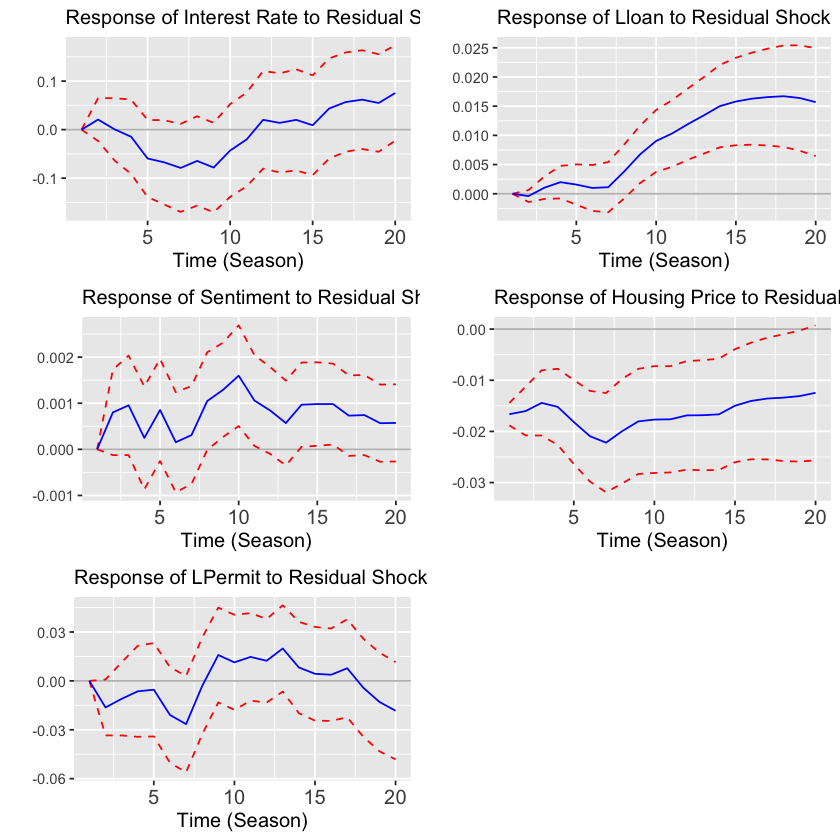

In [44]:
# For shock 1
multiplot(p1,p2,p3,p4,p5,
          cols = 2)
save_png(filename = "result/figure/IRF_sd_neg_shock1.png",
         plot = multiplot(p1,p2,p3,p4,p5,
                          cols = 2)
        )
# For shock 2
multiplot(p6,p7,p8,p9,p10,
          cols = 2)
save_png(filename = "result/figure/IRF_sd_neg_shock2.png",
         plot = multiplot(p6,p7,p8,p9,p10,
                          cols = 2)
        )
# For shock 3
multiplot(p11,p12,p13,p14,p15,
          cols = 2)
save_png(filename = "result/figure/IRF_sd_neg_shock3.png",
         plot = multiplot(p11,p12,p13,p14,p15,
                          cols = 2)
        )
# For shock 4
multiplot(p16,p17,p18,p19,p20,
          cols = 2)
save_png(filename = "result/figure/IRF_sd_neg_shock4.png",
         plot = multiplot(p16,p17,p18,p19,p20,
                          cols = 2)
        )
# For shock 5
multiplot(p21,p22,p23,p24,p25,
          cols = 2)
save_png(filename = "result/figure/IRF_sd_neg_shock5.png",
         plot = multiplot(p21,p22,p23,p24,p25,
                          cols = 2)
        )


### Negative Unit Monetary Policy Shock (still using bootstrap sd)

In [45]:
rescaling_factor <- as.numeric(df_IRF_plot_negative[1,1])

rescale_unit <- function(col_vec){
    rescaled_vec <- c()
    for(r in 1:20){
        rescaled_vec <- c(rescaled_vec, col_vec[r] / rescaling_factor)
    }
    return(rescaled_vec)
}

# rescale
df_IRF_plot.BS.L <- df_IRF_plot.BS.L %>% mutate_all(~ rescale_unit(.))
df_IRF_plot.BS.U <- df_IRF_plot.BS.U %>% mutate_all(~ rescale_unit(.))
df_IRF_plot.BS <- df_IRF_plot.BS %>% mutate_all(~ rescale_unit(.))

In [46]:
write.csv(df_IRF_plot.BS.L, "result/table/IRF_BS_L.csv")
write.csv(df_IRF_plot.BS.U, "result/table/IRF_BS_U.csv")
write.csv(df_IRF_plot.BS, "result/table/IRF_BS_Actual.csv")

New names:
* V1 -> V1...1
* V1 -> V1...2
* V1 -> V1...3

New names:
* V2 -> V2...1
* V2 -> V2...2
* V2 -> V2...3

New names:
* V3 -> V3...1
* V3 -> V3...2
* V3 -> V3...3

New names:
* V4 -> V4...1
* V4 -> V4...2
* V4 -> V4...3

New names:
* V5 -> V5...1
* V5 -> V5...2
* V5 -> V5...3

New names:
* V6 -> V6...1
* V6 -> V6...2
* V6 -> V6...3

New names:
* V7 -> V7...1
* V7 -> V7...2
* V7 -> V7...3

New names:
* V8 -> V8...1
* V8 -> V8...2
* V8 -> V8...3

New names:
* V9 -> V9...1
* V9 -> V9...2
* V9 -> V9...3

New names:
* V10 -> V10...1
* V10 -> V10...2
* V10 -> V10...3

New names:
* V11 -> V11...1
* V11 -> V11...2
* V11 -> V11...3

New names:
* V12 -> V12...1
* V12 -> V12...2
* V12 -> V12...3

New names:
* V13 -> V13...1
* V13 -> V13...2
* V13 -> V13...3

New names:
* V14 -> V14...1
* V14 -> V14...2
* V14 -> V14...3

New names:
* V15 -> V15...1
* V15 -> V15...2
* V15 -> V15...3

New names:
* V16 -> V16...1
* V16 -> V16...2
* V16 -> V16...3

New names:
* V17 -> V17...1
* V17 -> V17...2
*

pdf 
  2

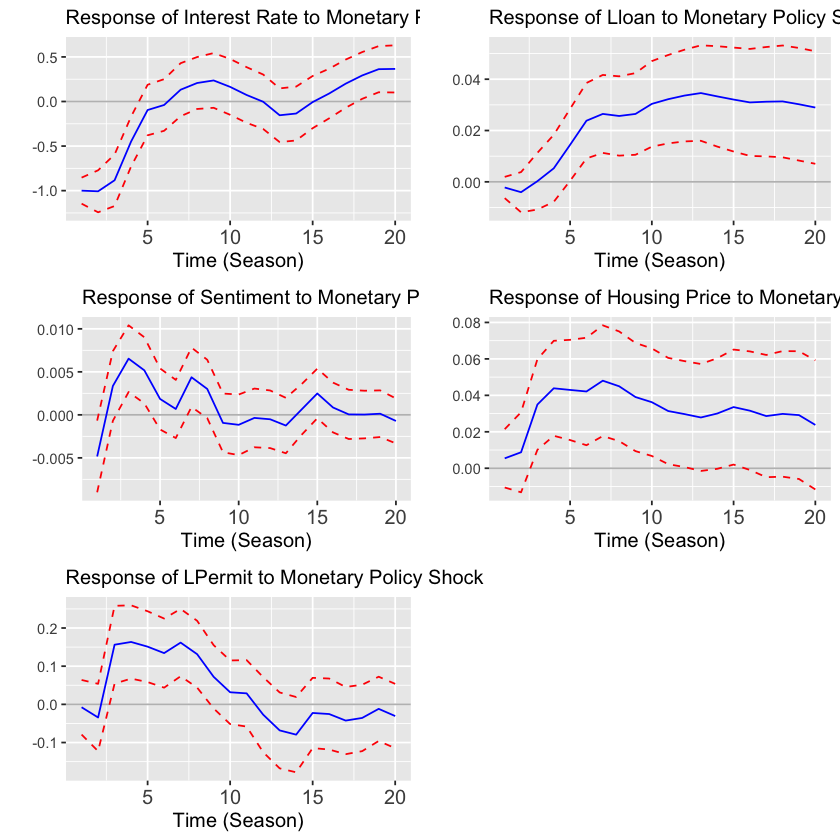

pdf 
  2

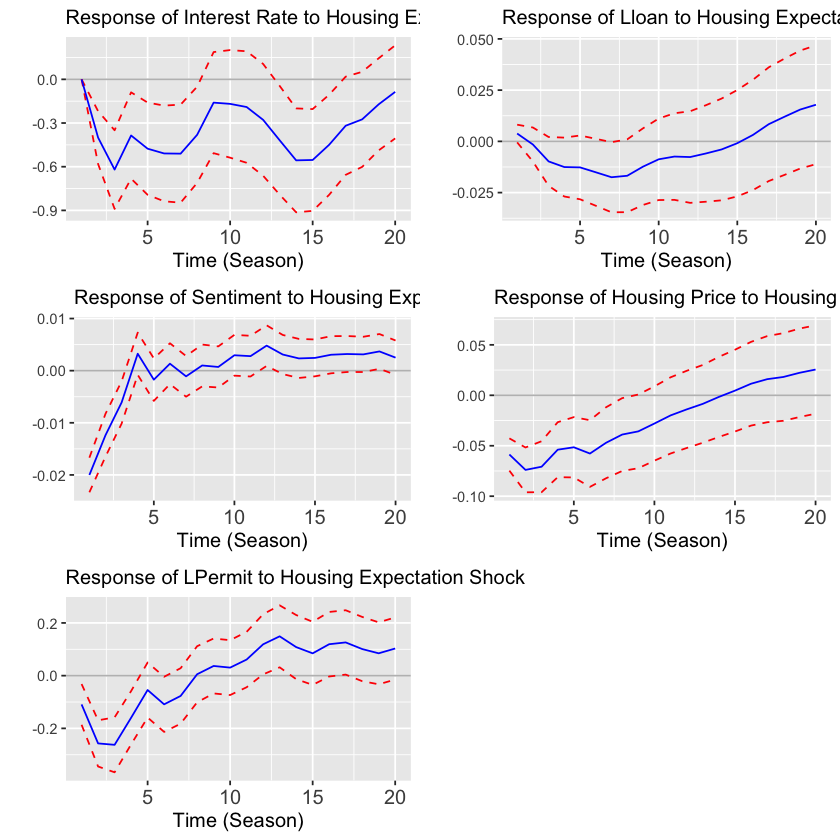

pdf 
  2

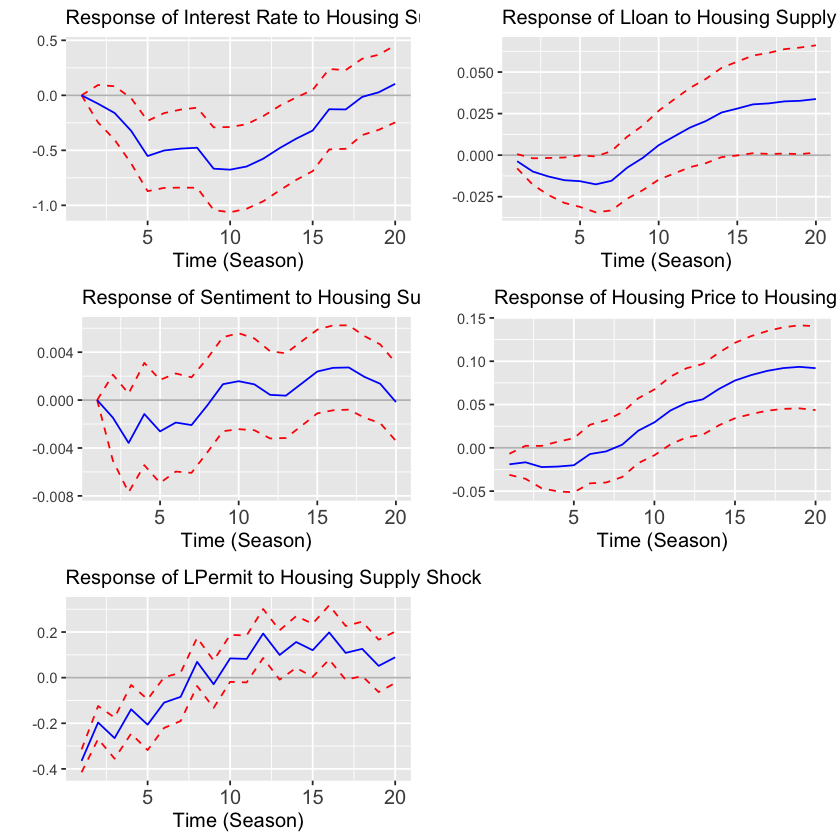

pdf 
  2

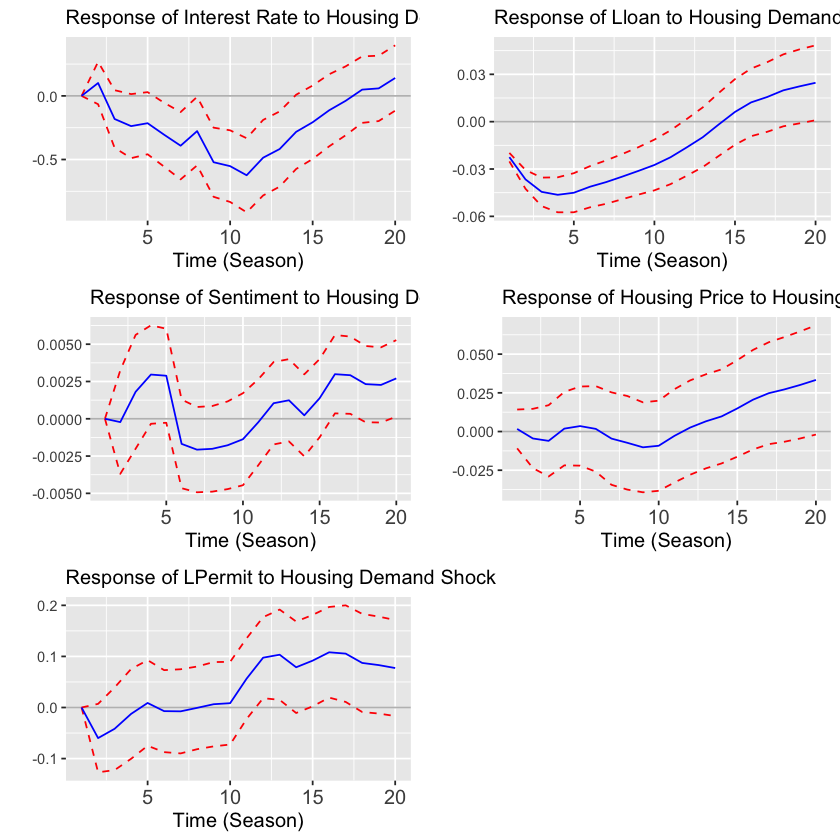

pdf 
  2

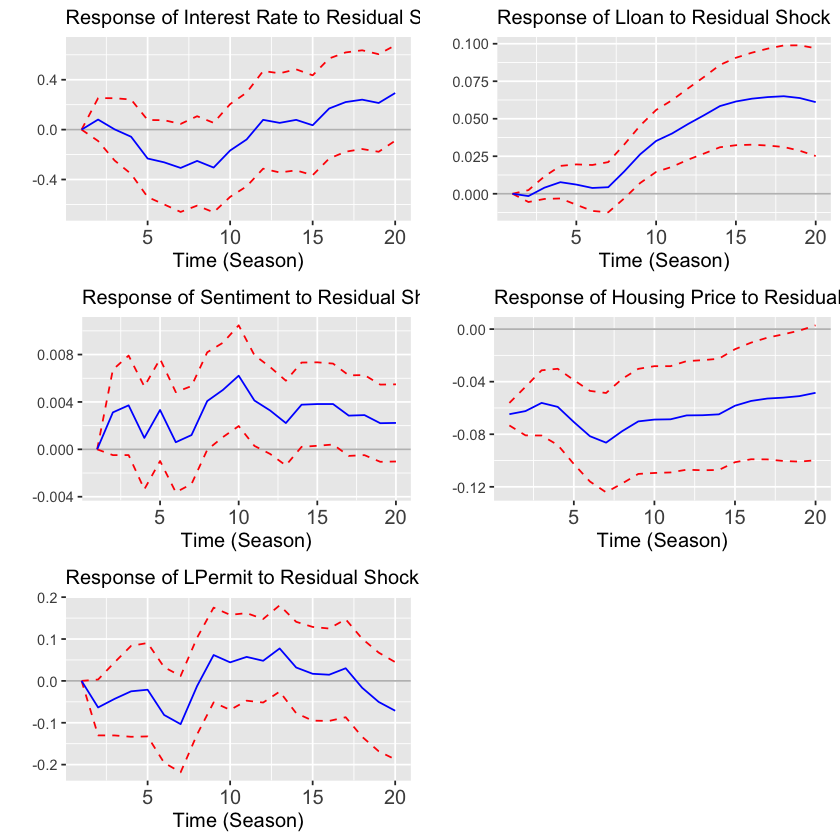

In [47]:
# lot
ind <- 0
for(i in 1:5){
  for(j in 1:5){
    ind <- ind+1
    nam <- paste("shock", j, "y", i, sep = '')
#     assign(nam, bind_cols(df_IRF_plot.BS.L[ind], df_IRF_plot.BS.U[ind],
#                           df_IRF_plot.BS.Median[ind], df_IRF_plot.BS.Mean[ind],
#                           df_IRF_plot.BS[ind]))
      assign(nam, bind_cols(df_IRF_plot.BS.L[ind], df_IRF_plot.BS.U[ind],
                            df_IRF_plot.BS[ind]))


    # 改名
    evalStr <- paste0("colnames(", nam, ") <- c('Lower', 'Upper', 'Actual')")
    eval(parse(text=evalStr))
    # 圖層
    evalStr <- paste0("p", ind, " <- ", "ggplot(",nam,") +geom_hline(yintercept=0, color = 'grey')+ geom_line(aes(x = 1:nrow(", nam, "), y = Lower), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Upper), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Actual), col = 'Blue')")
    eval(parse(text=evalStr))
  }
}

Text_Size_Theme = theme(
  axis.title.x = element_text(size = 12),
  axis.text.x = element_text(size = 12),
  axis.title.y = element_text(size = 12),
  axis.title = element_text(size = 12),
  plot.title = element_text(size=12))

## shock1: mp
p1 <- p1+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Monetary Policy Shock')+Text_Size_Theme
p2 <- p2+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Monetary Policy Shock')+Text_Size_Theme
p3 <- p3+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Monetary Policy Shock')+Text_Size_Theme
p4 <- p4+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Monetary Policy Shock')+Text_Size_Theme
p5 <- p5+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Monetary Policy Shock')+Text_Size_Theme

## shock2: exp
p6 <- p6+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Expectation Shock')+Text_Size_Theme
p7 <- p7+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Expectation Shock')+Text_Size_Theme
p8 <- p8+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Expectation Shock')+Text_Size_Theme
p9 <- p9+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Housing Expectation Shock')+Text_Size_Theme
p10 <- p10+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Expectation Shock')+Text_Size_Theme

## shock3: supply
p11 <- p11+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Supply Shock')+Text_Size_Theme
p12 <- p12+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Supply Shock')+Text_Size_Theme
p13 <- p13+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Supply Shock')+Text_Size_Theme
p14 <- p14+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Housing Supply Shock')+Text_Size_Theme
p15 <- p15+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Supply Shock')+Text_Size_Theme




## shock4: demand
p16 <- p16+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Demand Shock')+Text_Size_Theme
p17 <- p17+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Demand Shock')+Text_Size_Theme
p18 <- p18+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Demand Shock')+Text_Size_Theme
p19 <- p19+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Housing Demand Shock')+Text_Size_Theme
p20 <- p20+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Demand Shock')+Text_Size_Theme



## shock5: sp
p21 <- p21+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Residual Shock')+Text_Size_Theme
p22 <- p22+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Residual Shock')+Text_Size_Theme
p23 <- p23+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Residual Shock')+Text_Size_Theme
p24 <- p24+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Lloan to Residual Shock')+Text_Size_Theme
p25 <- p25+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Residual Shock')+Text_Size_Theme


# For shock 1
multiplot(p1,p2,p3,p4,p5,
          cols = 2)
save_png(filename = "result/figure/IRF_unit_neg_shock1.png",
         plot = multiplot(p1,p2,p3,p4,p5,
                          cols = 2)
        )
# For shock 2
multiplot(p6,p7,p8,p9,p10,
          cols = 2)
save_png(filename = "result/figure/IRF_unit_neg_shock2.png",
         plot = multiplot(p6,p7,p8,p9,p10,
                          cols = 2)
        )
# For shock 3
multiplot(p11,p12,p13,p14,p15,
          cols = 2)
save_png(filename = "result/figure/IRF_unit_neg_shock3.png",
         plot = multiplot(p11,p12,p13,p14,p15,
                          cols = 2)
        )
# For shock 4
multiplot(p16,p17,p18,p19,p20,
          cols = 2)
save_png(filename = "result/figure/IRF_unit_neg_shock4.png",
         plot = multiplot(p16,p17,p18,p19,p20,
                          cols = 2)
        )
# For shock 5
multiplot(p21,p22,p23,p24,p25,
          cols = 2)
save_png(filename = "result/figure/IRF_unit_neg_shock5.png",
         plot = multiplot(p21,p22,p23,p24,p25,
                          cols = 2)
        )

## 畫IRF & Bootstrap C.I. (Using Bootstrap median, and 97.5% Upper, 2.5% Lower bound)

In [48]:
df_IRF_plot.BS.L <- matrix(NA, nrow = hrz+1, ncol = 25)
df_IRF_plot.BS.U <- matrix(NA, nrow = hrz+1, ncol = 25)
df_IRF_plot.BS.Median <- matrix(NA, nrow = hrz+1, ncol = 25)
df_IRF_plot.BS.Mean <- matrix(NA, nrow = hrz+1, ncol = 25)
for(col in 1:25){
  for(row in 1:(hrz+1) ){
    df_IRF_plot.BS.L[row,col] <- quantile(df_IRF.sim[row,col,], probs = 0.025)
    df_IRF_plot.BS.U[row,col] <- quantile(df_IRF.sim[row,col,], probs = 0.975)
    df_IRF_plot.BS.Median[row,col] <- quantile(df_IRF.sim[row,col,], probs = 0.5)
    df_IRF_plot.BS.Mean[row,col] <- mean(df_IRF.sim[row,col,])
  }
}

df_IRF_plot.BS.L <- df_IRF_plot.BS.L %>% as_tibble()
df_IRF_plot.BS.U <- df_IRF_plot.BS.U %>% as_tibble()
df_IRF_plot.BS.Median <- df_IRF_plot.BS.Median %>% as_tibble()
df_IRF_plot.BS.Mean <- df_IRF_plot.BS.Mean %>% as_tibble()

In [49]:
ind <- 0
for(i in 1:5){
  for(j in 1:5){
    ind <- ind+1
    nam <- paste("shock", j, "y", i, sep = '')
    assign(nam, bind_cols(df_IRF_plot.BS.L[ind], df_IRF_plot.BS.U[ind],
                          df_IRF_plot.BS.Median[ind], df_IRF_plot.BS.Mean[ind],
                          df_IRF_plot[ind]))
    # 改名
    evalStr <- paste0("colnames(", nam, ") <- c('Lower', 'Upper', 'Median', 'Mean', 'Actual')")
    eval(parse(text=evalStr))
    # 圖層
    evalStr <- paste0("p", ind, " <- ", "ggplot(",nam,") +geom_hline(yintercept=0, color = 'grey')+ geom_line(aes(x = 1:nrow(", nam, "), y = Lower), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Upper), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Median), col = 'Blue')")
    eval(parse(text=evalStr))
  }
}

New names:
* V1 -> V1...1
* V1 -> V1...2
* V1 -> V1...3
* V1 -> V1...4
* V1 -> V1...5

New names:
* V2 -> V2...1
* V2 -> V2...2
* V2 -> V2...3
* V2 -> V2...4
* V2 -> V2...5

New names:
* V3 -> V3...1
* V3 -> V3...2
* V3 -> V3...3
* V3 -> V3...4
* V3 -> V3...5

New names:
* V4 -> V4...1
* V4 -> V4...2
* V4 -> V4...3
* V4 -> V4...4
* V4 -> V4...5

New names:
* V5 -> V5...1
* V5 -> V5...2
* V5 -> V5...3
* V5 -> V5...4
* V5 -> V5...5

New names:
* V6 -> V6...1
* V6 -> V6...2
* V6 -> V6...3
* V6 -> V6...4
* V6 -> V6...5

New names:
* V7 -> V7...1
* V7 -> V7...2
* V7 -> V7...3
* V7 -> V7...4
* V7 -> V7...5

New names:
* V8 -> V8...1
* V8 -> V8...2
* V8 -> V8...3
* V8 -> V8...4
* V8 -> V8...5

New names:
* V9 -> V9...1
* V9 -> V9...2
* V9 -> V9...3
* V9 -> V9...4
* V9 -> V9...5

New names:
* V10 -> V10...1
* V10 -> V10...2
* V10 -> V10...3
* V10 -> V10...4
* V10 -> V10...5

New names:
* V11 -> V11...1
* V11 -> V11...2
* V11 -> V11...3
* V11 -> V11...4
* V11 -> V11...5

New names:
* V12 -> V12

In [50]:
Text_Size_Theme = theme(
  axis.title.x = element_text(size = 12),
  axis.text.x = element_text(size = 12),
  axis.title.y = element_text(size = 12),
  axis.title = element_text(size = 12),
  plot.title = element_text(size=12))

## shock1: mp
p1 <- p1+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Monetary Policy Shock')+Text_Size_Theme
p2 <- p2+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Monetary Policy Shock')+Text_Size_Theme
p3 <- p3+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Monetary Policy Shock')+Text_Size_Theme
p4 <- p4+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of dLloan to Monetary Policy Shock')+Text_Size_Theme
p5 <- p5+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Monetary Policy Shock')+Text_Size_Theme

## shock2: exp
p6 <- p6+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Expectation Shock')+Text_Size_Theme
p7 <- p7+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Expectation Shock')+Text_Size_Theme
p8 <- p8+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Expectation Shock')+Text_Size_Theme
p9 <- p9+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of dLloan to Housing Expectation Shock')+Text_Size_Theme
p10 <- p10+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Expectation Shock')+Text_Size_Theme

## shock3: supply
p11 <- p11+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Supply Shock')+Text_Size_Theme
p12 <- p12+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Supply Shock')+Text_Size_Theme
p13 <- p13+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Supply Shock')+Text_Size_Theme
p14 <- p14+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of dLloan to Housing Supply Shock')+Text_Size_Theme
p15 <- p15+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Supply Shock')+Text_Size_Theme




## shock4: demand
p16 <- p16+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Demand Shock')+Text_Size_Theme
p17 <- p17+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Demand Shock')+Text_Size_Theme
p18 <- p18+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Demand Shock')+Text_Size_Theme
p19 <- p19+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of dLloan to Housing Demand Shock')+Text_Size_Theme
p20 <- p20+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Demand Shock')+Text_Size_Theme



## shock5: sp
p21 <- p21+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Residual Shock')+Text_Size_Theme
p22 <- p22+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Residual Shock')+Text_Size_Theme
p23 <- p23+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Residual Shock')+Text_Size_Theme
p24 <- p24+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of dLloan to Residual Shock')+Text_Size_Theme
p25 <- p25+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Residual Shock')+Text_Size_Theme

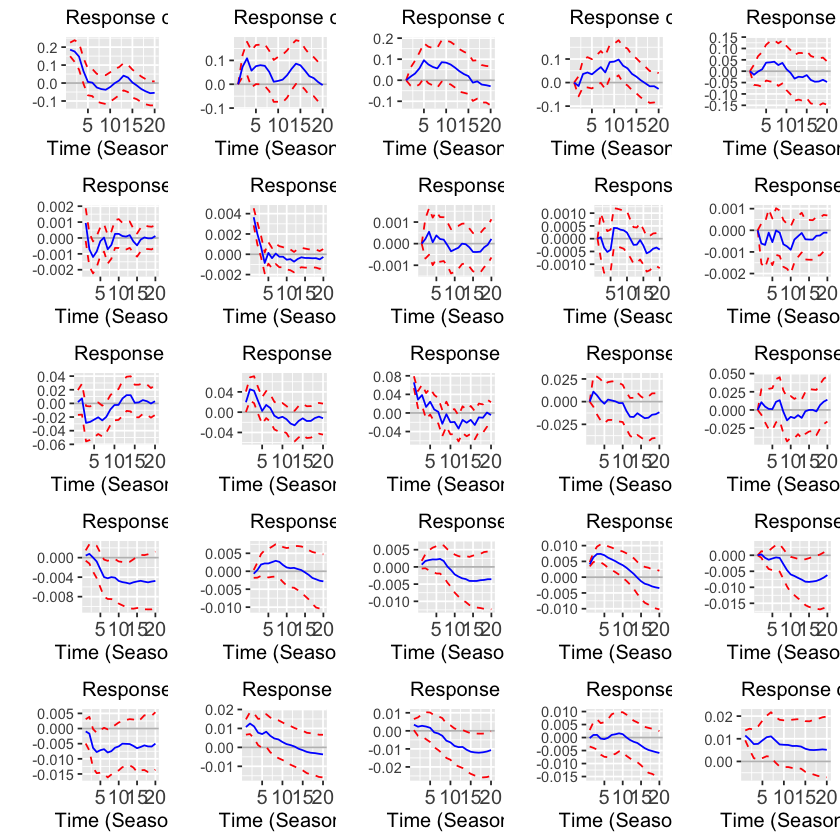

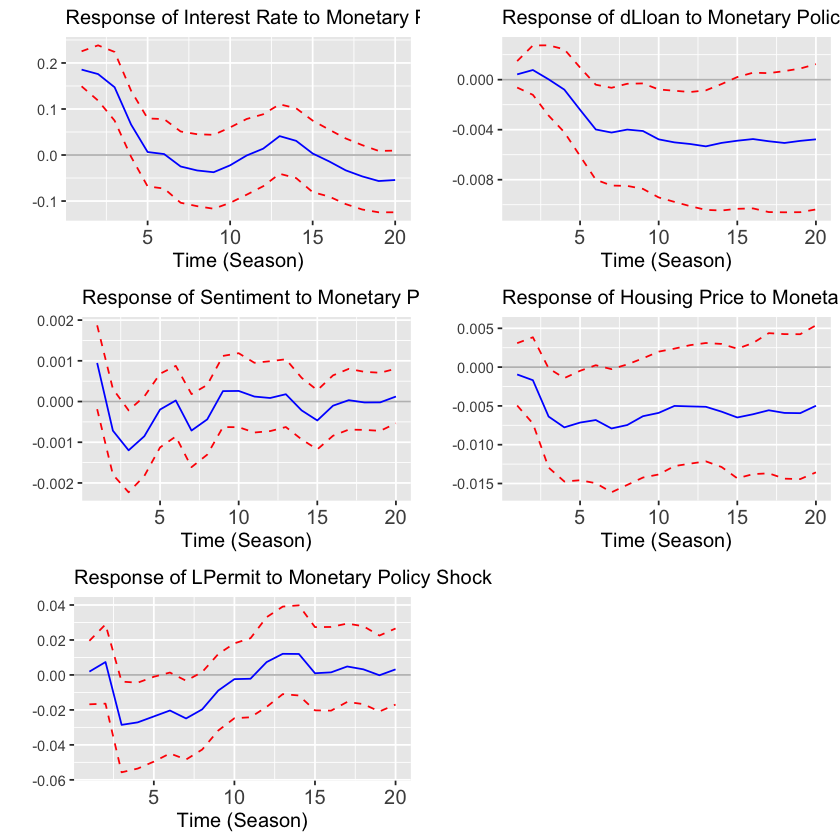

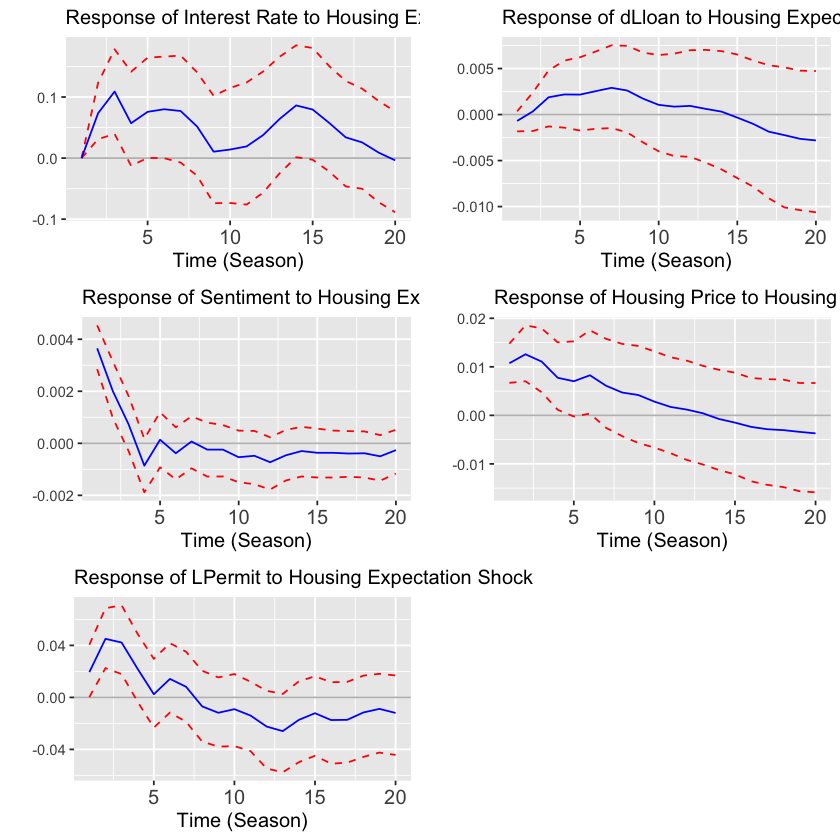

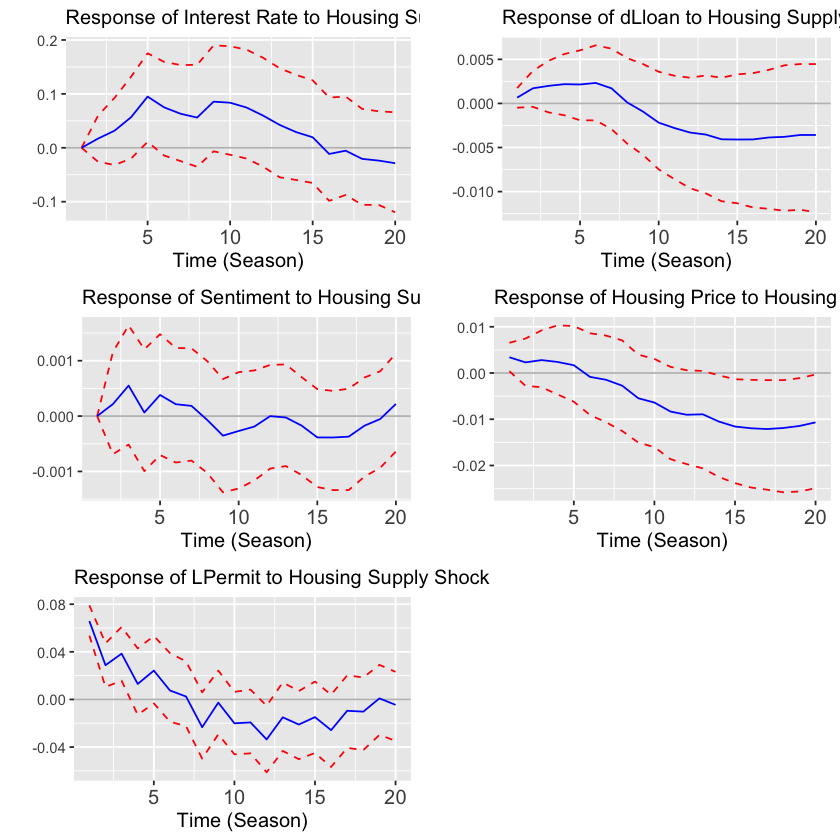

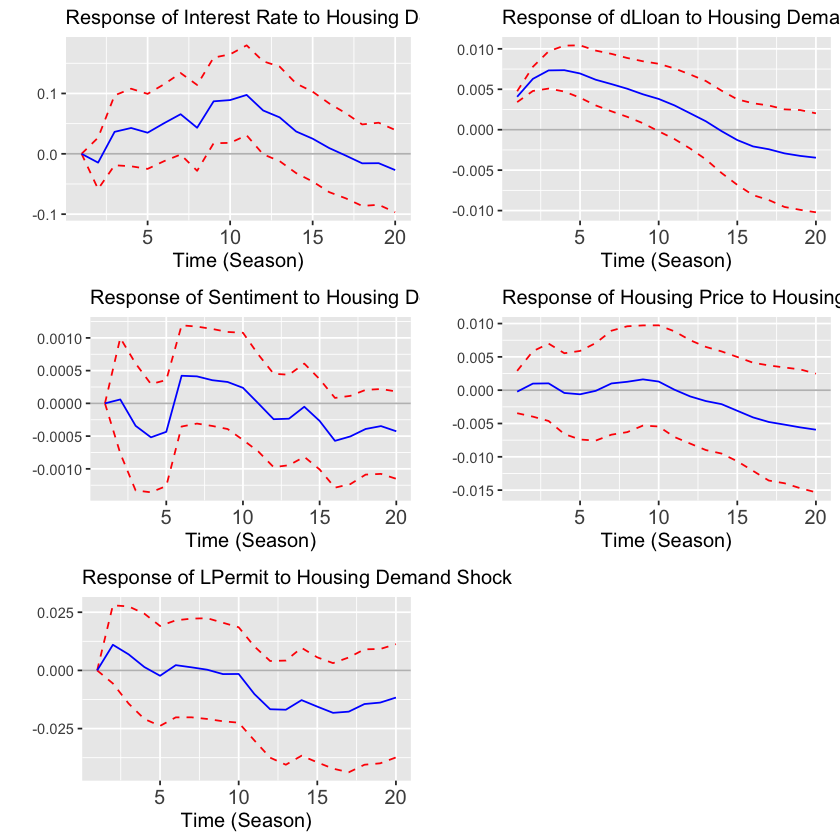

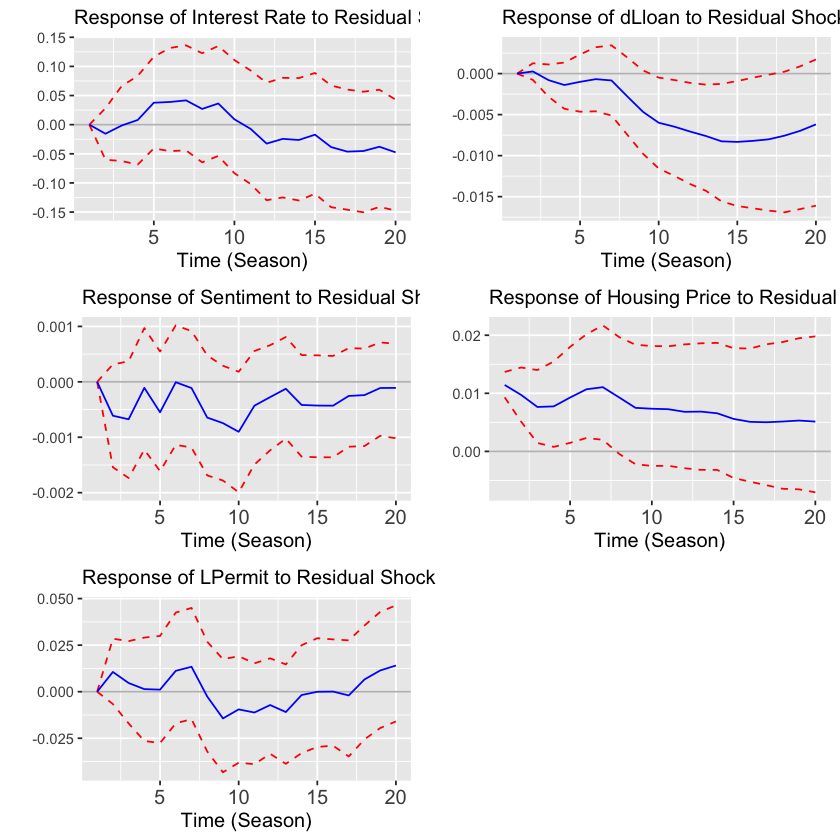

In [51]:
multiplot(p1,p2,p3,p4,p5,
          p6,p7,p8,p9,p10,
          p11,p12,p13,p14,p15,
          p16,p17,p18,p19,p20,
          p21,p22,p23,p24,p25,
          cols = 5)
# For shock 1
multiplot(p1,p2,p3,p4,p5,
          cols = 2)
# For shock 2
multiplot(p6,p7,p8,p9,p10,
          cols = 2)
# For shock 3
multiplot(p11,p12,p13,p14,p15,
          cols = 2)
# For shock 4
multiplot(p16,p17,p18,p19,p20,
          cols = 2)
# For shock 5
multiplot(p21,p22,p23,p24,p25,
          cols = 2)

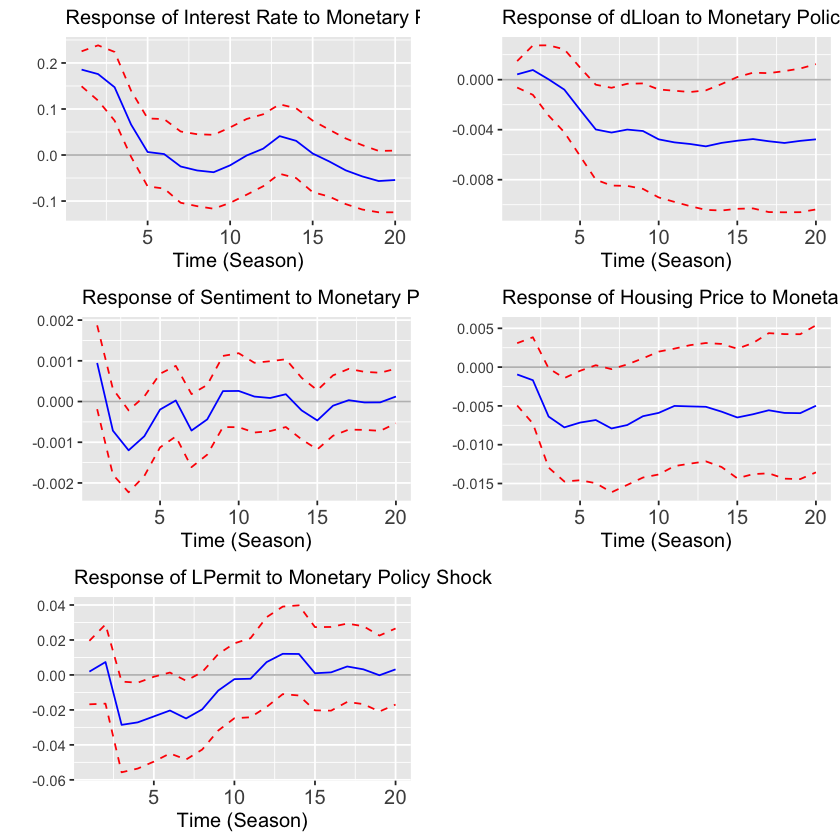

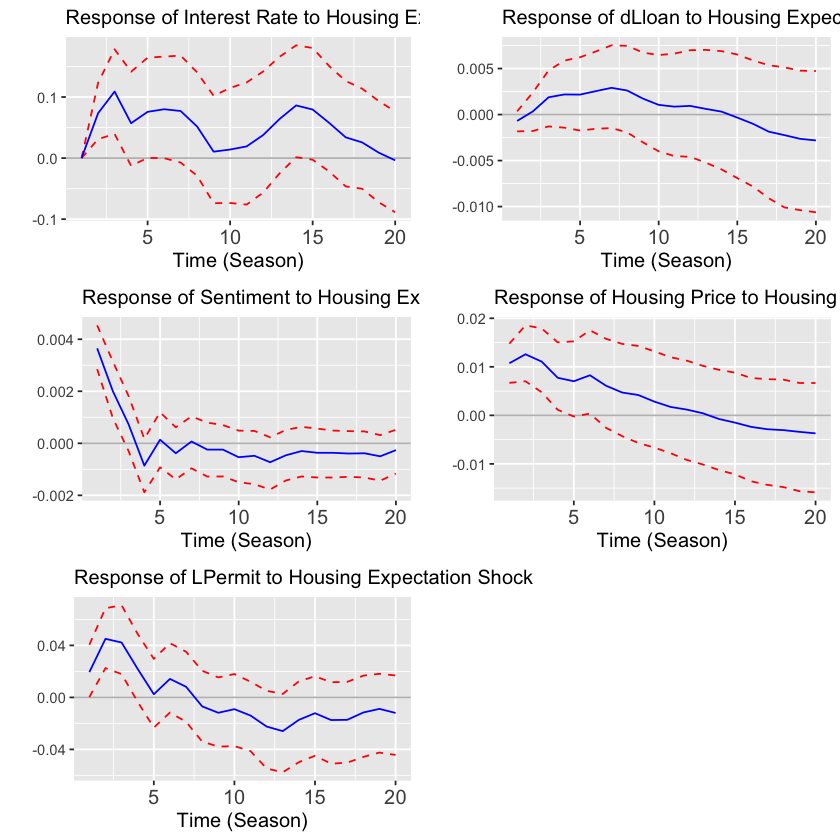

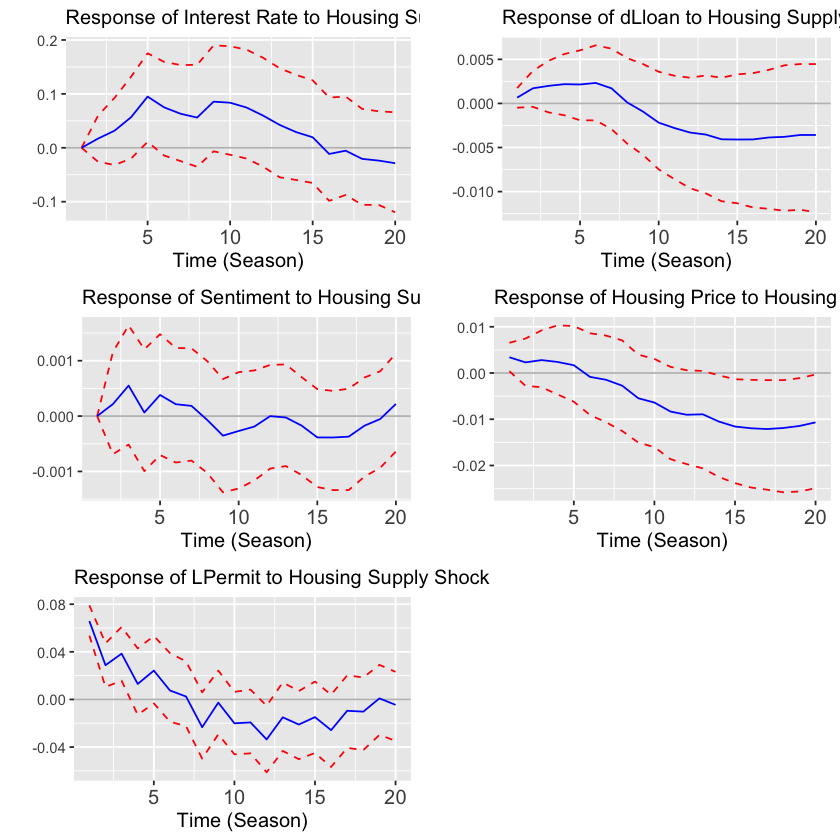

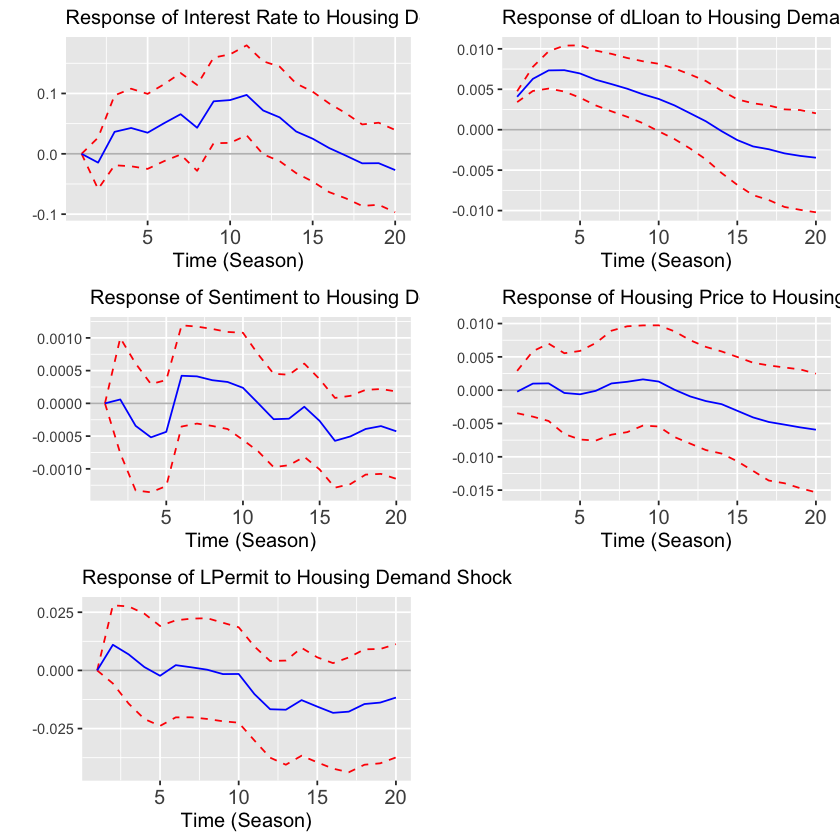

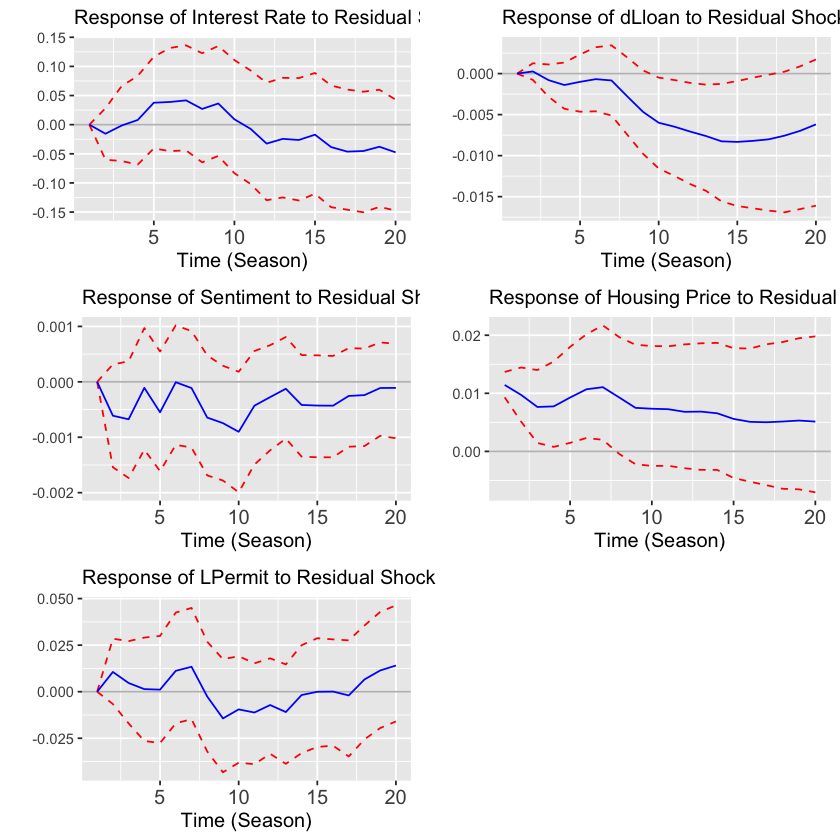

In [52]:
# save plot
# shock 1
ggsave(filename = "result/figure/0219_m1_IRF_shock1.png", 
       plot = multiplot(p1,p2,p3,p4,p5, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 2
ggsave(filename = "result/figure/0219_m1_IRF_shock2.png", 
       plot = multiplot(p6,p7,p8,p9,p10, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 3
ggsave(filename = "result/figure/0219_m1_IRF_shock3.png", 
       plot = multiplot(p11,p12,p13,p14,p15, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 4
ggsave(filename = "result/figure/0219_m1_IRF_shock4.png",
       plot = multiplot(p16,p17,p18,p19,p20, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 5
ggsave(filename = "result/figure/0219_m1_IRF_shock5.png",
       plot = multiplot(p21,p22,p23,p24,p25, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

### Saving all IRF

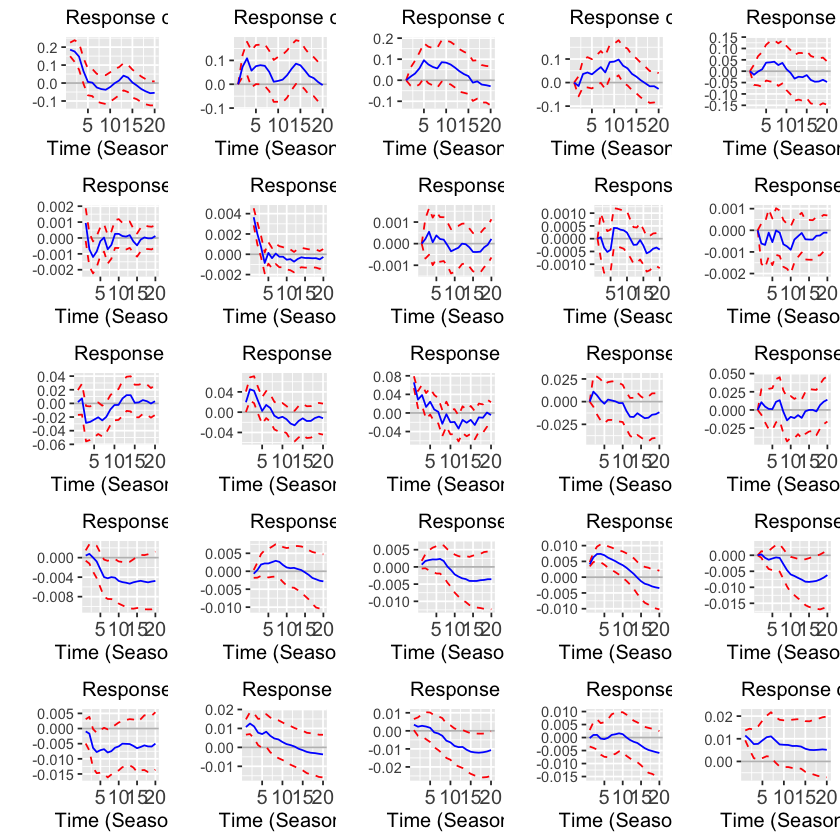

In [53]:
# For all IRF
ggsave(filename = "result/figure/imp.png", 
       plot = multiplot(p1,p2,p3,p4,p5,
                        p6,p7,p8,p9,p10,
                        p11,p12,p13,p14,p15,
                        p16,p17,p18,p19,p20,
                        p21,p22,p23,p24,p25,
                        cols = 5),
       width = 15*2, height = 10*2, units = "cm",
       device = "png")

### 考量shock sign後

In [54]:
print(shock_sign)

[1] -1


In [55]:
df_IRF_plot.BS.L_negative <- (df_IRF_plot.BS.L*shock_sign) %>% as_tibble()
df_IRF_plot.BS.U_negative <- (df_IRF_plot.BS.U*shock_sign) %>% as_tibble()
df_IRF_plot.BS.Median_negative <- (df_IRF_plot.BS.Median*shock_sign) %>% as_tibble()
df_IRF_plot.BS.Mean_negative <- (df_IRF_plot.BS.Mean*shock_sign) %>% as_tibble()
df_IRF_plot_negative <- (df_IRF_plot*shock_sign) %>% as_tibble()

ind <- 0
for(i in 1:5){
  for(j in 1:5){
    ind <- ind+1
    nam <- paste("shock", j, "y", i,"_negative", sep = '')
    assign(nam, bind_cols(df_IRF_plot.BS.L_negative[ind], df_IRF_plot.BS.U_negative[ind],
                          df_IRF_plot.BS.Median_negative[ind], df_IRF_plot.BS.Mean_negative[ind],
                          df_IRF_plot_negative[ind]))
    # 改名
    evalStr <- paste0("colnames(", nam, ") <- c('Lower', 'Upper', 'Median', 'Mean', 'Actual')")
    eval(parse(text=evalStr))
    # 圖層
    evalStr <- paste0("p", ind, " <- ", "ggplot(",nam,") +geom_hline(yintercept=0, color = 'grey')+ geom_line(aes(x = 1:nrow(", nam, "), y = Lower), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Upper), linetype = 'dashed', col='red')+geom_line(aes(x = 1:nrow(", nam, "), y = Median), col = 'Blue')")
    eval(parse(text=evalStr))
  }
}

New names:
* V1 -> V1...1
* V1 -> V1...2
* V1 -> V1...3
* V1 -> V1...4
* V1 -> V1...5

New names:
* V2 -> V2...1
* V2 -> V2...2
* V2 -> V2...3
* V2 -> V2...4
* V2 -> V2...5

New names:
* V3 -> V3...1
* V3 -> V3...2
* V3 -> V3...3
* V3 -> V3...4
* V3 -> V3...5

New names:
* V4 -> V4...1
* V4 -> V4...2
* V4 -> V4...3
* V4 -> V4...4
* V4 -> V4...5

New names:
* V5 -> V5...1
* V5 -> V5...2
* V5 -> V5...3
* V5 -> V5...4
* V5 -> V5...5

New names:
* V6 -> V6...1
* V6 -> V6...2
* V6 -> V6...3
* V6 -> V6...4
* V6 -> V6...5

New names:
* V7 -> V7...1
* V7 -> V7...2
* V7 -> V7...3
* V7 -> V7...4
* V7 -> V7...5

New names:
* V8 -> V8...1
* V8 -> V8...2
* V8 -> V8...3
* V8 -> V8...4
* V8 -> V8...5

New names:
* V9 -> V9...1
* V9 -> V9...2
* V9 -> V9...3
* V9 -> V9...4
* V9 -> V9...5

New names:
* V10 -> V10...1
* V10 -> V10...2
* V10 -> V10...3
* V10 -> V10...4
* V10 -> V10...5

New names:
* V11 -> V11...1
* V11 -> V11...2
* V11 -> V11...3
* V11 -> V11...4
* V11 -> V11...5

New names:
* V12 -> V12

In [56]:
## shock1: mp
p1 <- p1+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Monetary Policy Shock')+Text_Size_Theme
p2 <- p2+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Monetary Policy Shock')+Text_Size_Theme
p3 <- p3+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Monetary Policy Shock')+Text_Size_Theme
p4 <- p4+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of dLloan to Monetary Policy Shock')+Text_Size_Theme
p5 <- p5+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Monetary Policy Shock')+Text_Size_Theme

## shock2: exp
p6 <- p6+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Expectation Shock')+Text_Size_Theme
p7 <- p7+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Expectation Shock')+Text_Size_Theme
p8 <- p8+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Expectation Shock')+Text_Size_Theme
p9 <- p9+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of dLloan to Housing Expectation Shock')+Text_Size_Theme
p10 <- p10+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Expectation Shock')+Text_Size_Theme

## shock3: supply
p11 <- p11+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Supply Shock')+Text_Size_Theme
p12 <- p12+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Supply Shock')+Text_Size_Theme
p13 <- p13+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Supply Shock')+Text_Size_Theme
p14 <- p14+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of dLloan to Housing Supply Shock')+Text_Size_Theme
p15 <- p15+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Supply Shock')+Text_Size_Theme




## shock4: demand
p16 <- p16+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Housing Demand Shock')+Text_Size_Theme
p17 <- p17+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Housing Demand Shock')+Text_Size_Theme
p18 <- p18+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Housing Demand Shock')+Text_Size_Theme
p19 <- p19+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of dLloan to Housing Demand Shock')+Text_Size_Theme
p20 <- p20+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Housing Demand Shock')+Text_Size_Theme



## shock5: sp
p21 <- p21+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Interest Rate to Residual Shock')+Text_Size_Theme
p22 <- p22+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Sentiment to Residual Shock')+Text_Size_Theme
p23 <- p23+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of LPermit to Residual Shock')+Text_Size_Theme
p24 <- p24+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of dLloan to Residual Shock')+Text_Size_Theme
p25 <- p25+labs(x = 'Time (Season)',
        y = '',
        title = 'Response of Housing Price to Residual Shock')+Text_Size_Theme

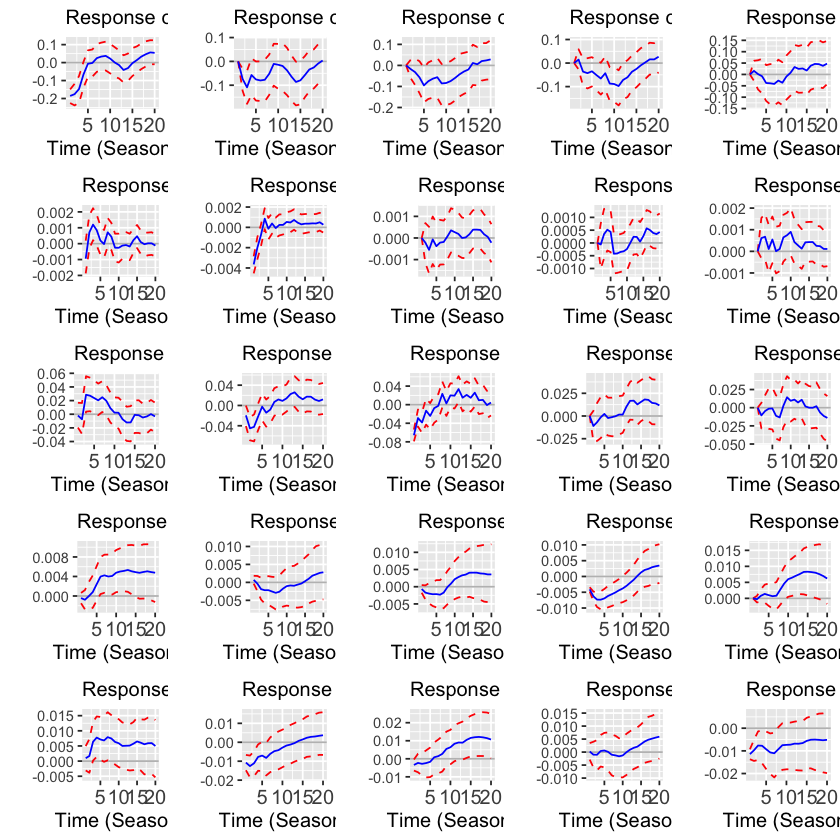

In [57]:
multiplot(p1,p2,p3,p4,p5,
          p6,p7,p8,p9,p10,
          p11,p12,p13,p14,p15,
          p16,p17,p18,p19,p20,
          p21,p22,p23,p24,p25,
          cols = 5)

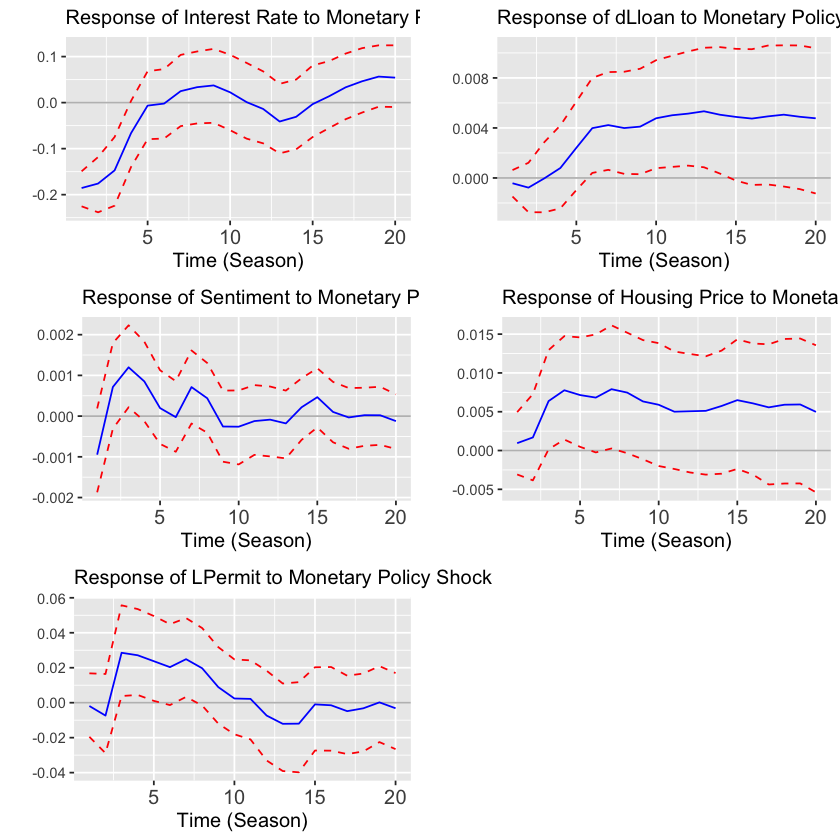

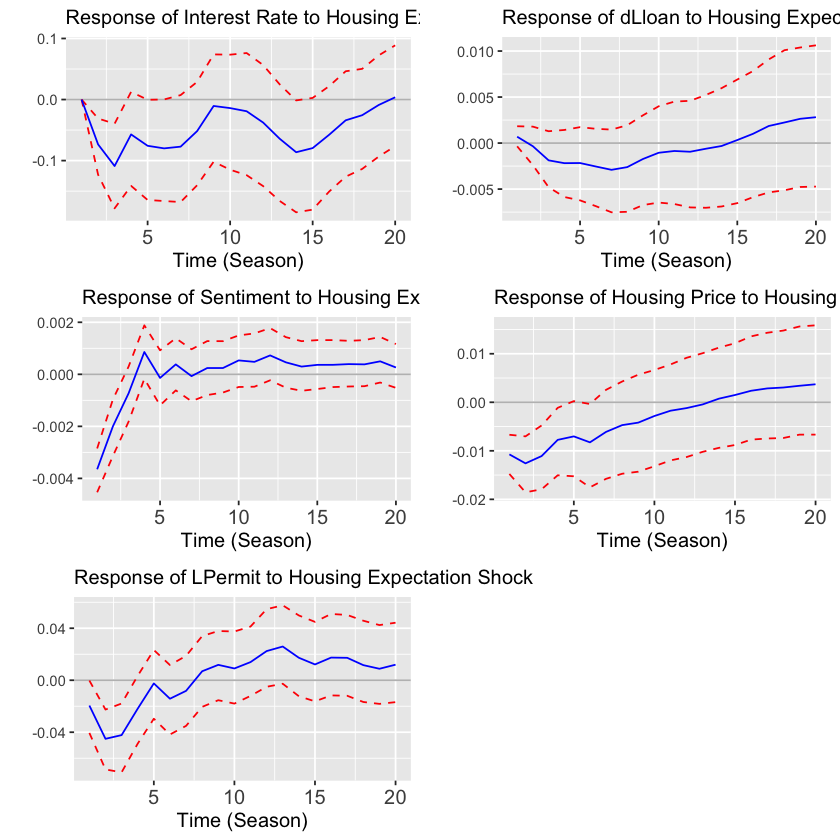

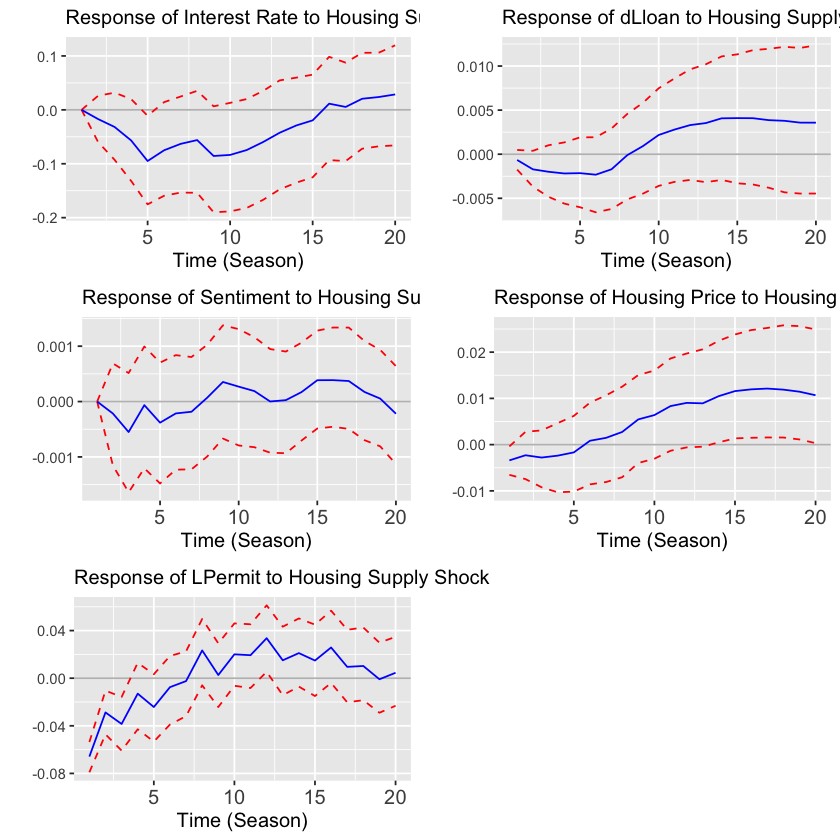

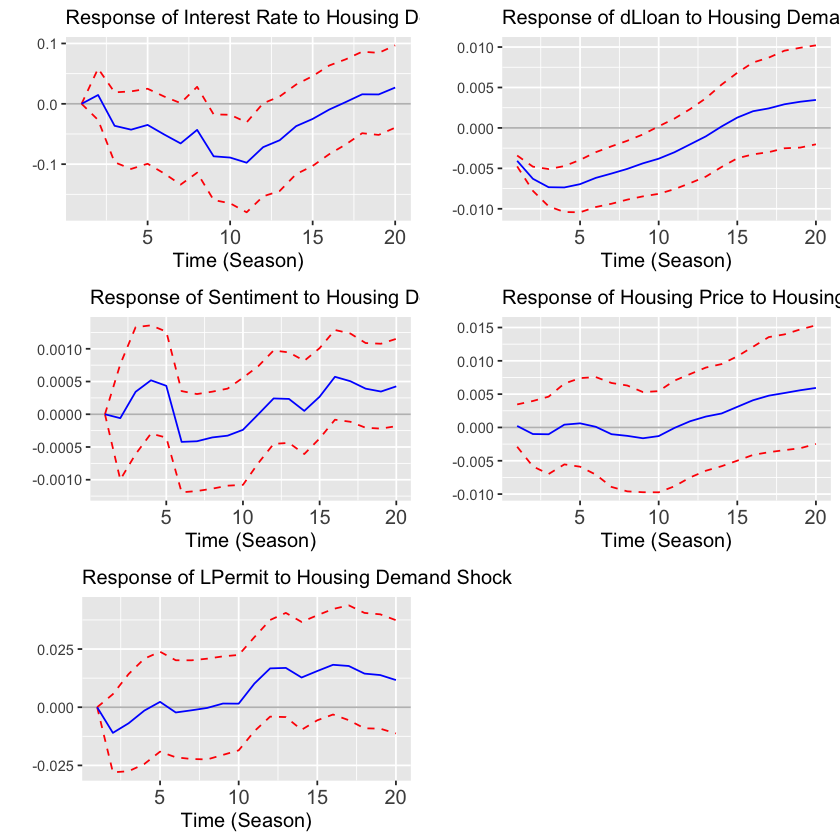

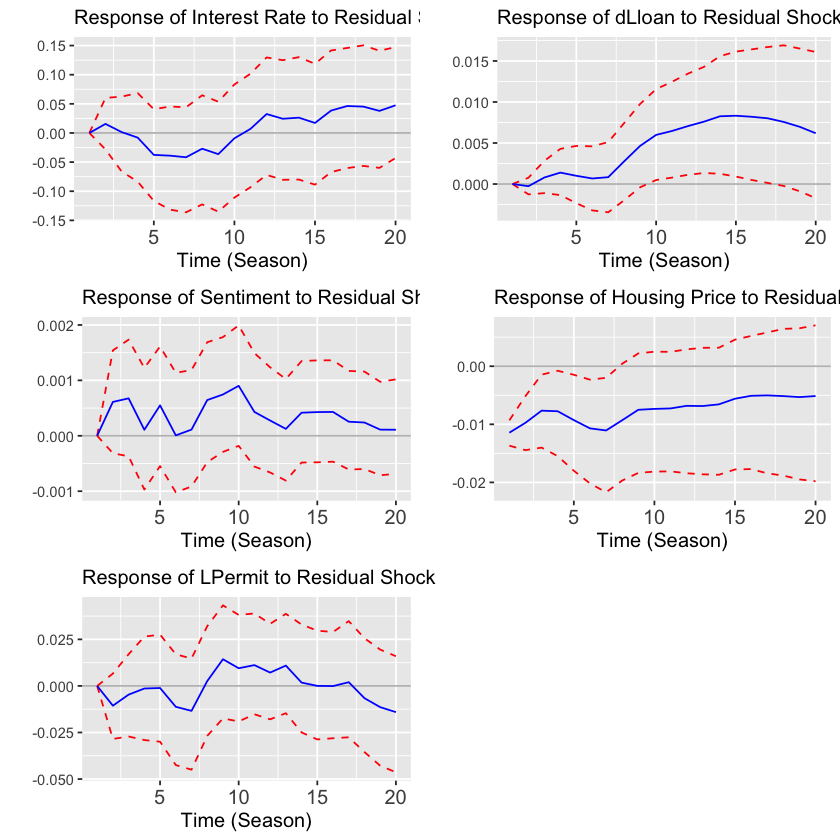

In [58]:
# For shock 1
multiplot(p1,p2,p3,p4,p5,
          cols = 2)
# For shock 2
multiplot(p6,p7,p8,p9,p10,
          cols = 2)
# For shock 3
multiplot(p11,p12,p13,p14,p15,
          cols = 2)
# For shock 4
multiplot(p16,p17,p18,p19,p20,
          cols = 2)
# For shock 5
multiplot(p21,p22,p23,p24,p25,
          cols = 2)

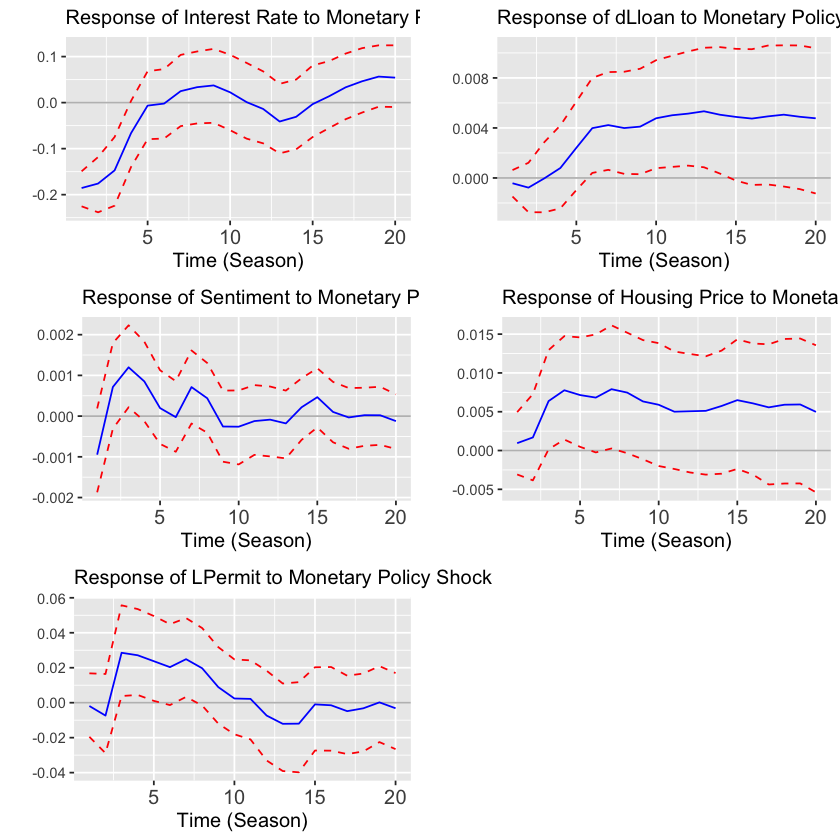

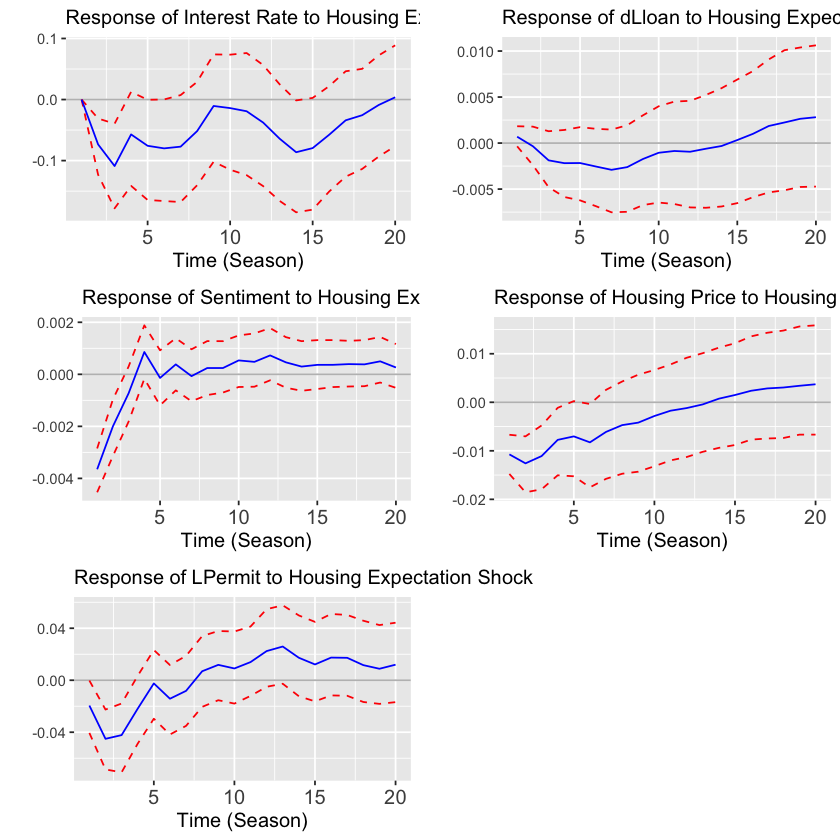

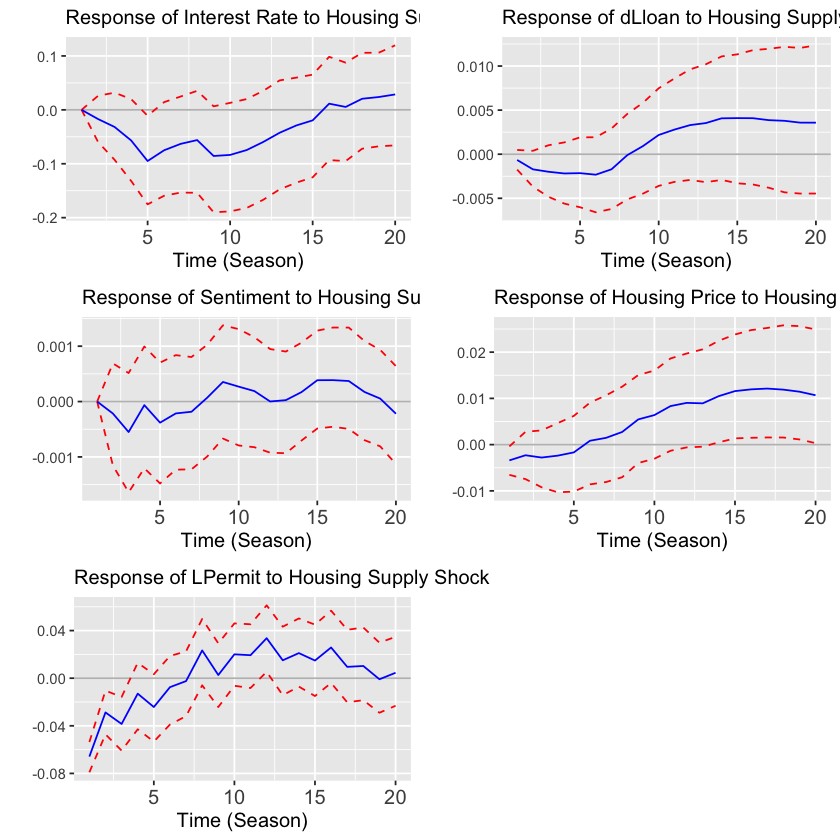

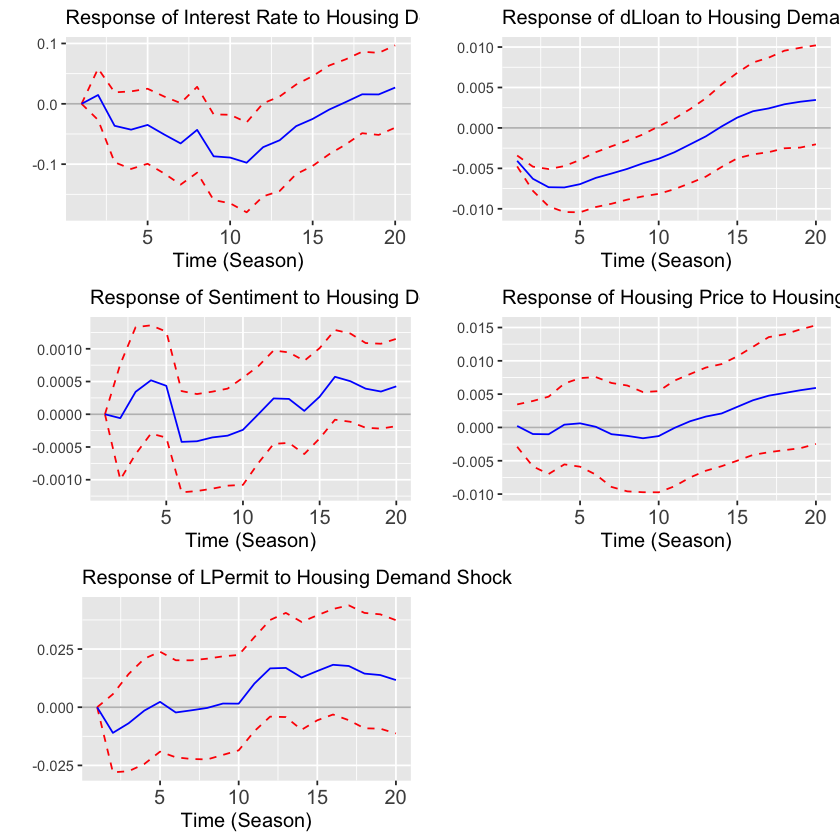

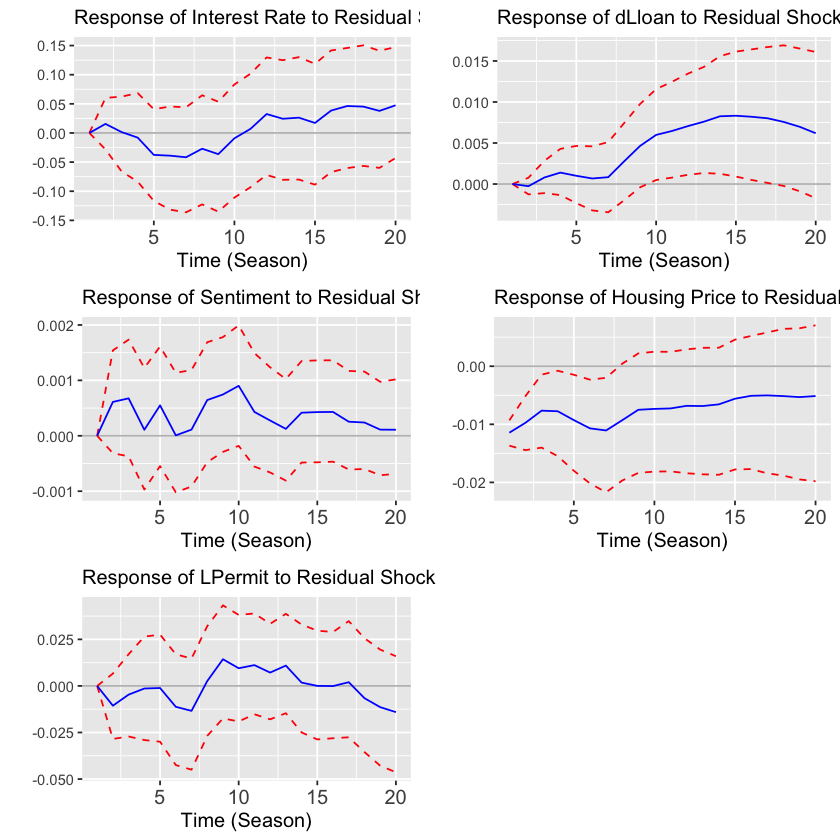

In [59]:
# save plot
# shock 1
ggsave(filename = "result/figure/0219_m1_IRF_shock1_negative.png", 
       plot = multiplot(p1,p2,p3,p4,p5, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 2
ggsave(filename = "result/figure/0219_m1_IRF_shock2_negative.png", 
       plot = multiplot(p6,p7,p8,p9,p10, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 3
ggsave(filename = "result/figure/0219_m1_IRF_shock3_negative.png", 
       plot = multiplot(p11,p12,p13,p14,p15, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 4
ggsave(filename = "result/figure/0219_m1_IRF_shock4_negative.png",
       plot = multiplot(p16,p17,p18,p19,p20, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

# shock 5
ggsave(filename = "result/figure/0219_m1_IRF_shock5_negative.png",
       plot = multiplot(p21,p22,p23,p24,p25, cols = 2),
       width = 30, height = 20, units = "cm",
       device = "png")

## Variance Decomposition

In [60]:
# `ddTheta` 放已經估出來的IRF (至於要放怎樣穩定的還要再想)
# m表示對於第幾個變數的變異數分解（如第五個是對房價的變異數分解）
SVAR_AB_VarDecomp <- VAR.svardecomp.AB(m = 5, By, VAR.P,
                                       AMat, BMat, h=(hrz+1),
                                       Const=TRUE, ddTheta = SVAR_AB_IRF)
# head(SVAR_AB_VarDecomp*100)
# tail(SVAR_AB_VarDecomp*100)
(SVAR_AB_VarDecomp*100)

[,1]       [,2]     [,3]      [,4]       [,5]    
h=1   0.3682224 42.87326  4.515365 0.03482753 52.20832
h=2   0.5996195 50.14900  3.612731 0.12906555 45.50959
h=3   4.8024727 50.27910  4.102596 0.21405911 40.60177
h=4   8.9187966 46.11050  4.397865 0.17201772 40.40082
h=5  10.9925515 41.97294  4.329859 0.16193294 42.54272
h=6  11.8121927 39.18671  3.540679 0.13413424 45.32629
h=7  13.0767540 35.62928  2.958907 0.14084354 48.19422
h=8  14.0329294 33.22662  2.618435 0.18997814 49.93204
h=9  14.4540384 31.57266  2.819432 0.29036774 50.86350
h=10 14.6503376 29.82540  3.494375 0.35493978 51.67495
h=11 14.4758005 27.92083  5.020502 0.33529008 52.24758
h=12 14.2162328 26.07385  7.077390 0.31686753 52.31566
h=13 13.8783724 24.33074  9.191788 0.33102271 52.26808
h=14 13.5236098 22.49526 12.047066 0.37949459 51.55457
h=15 13.2857575 20.78421 15.411234 0.50843210 50.01037
h=16 12.9296962 19.29070 18.863815 0.74751364 48.16828
h=17 12.4559940 17.99707 22.238570 1.06327564 46.24509
h=18 12.0347207 16.85170 25.358530 1.40117995 44.35387
h=19 11.6244436 15.91493 28.122536 1.77481329 42.56327
h=20 11.1543992 15.21210 30.450630 2.20362300 40.97924

In [61]:
# output entire table
VD_TABLE <- (SVAR_AB_VarDecomp*100) %>% as.tibble %>% select(mp=1,exp=2,hs=3,hd=4,hp=5)
write.table(VD_TABLE, file = "result/table/VD_TABLE.csv", sep = ",", row.names = FALSE)

In [62]:
# table
SVAR_VD <- (SVAR_AB_VarDecomp*100) %>% as.tibble()
SVAR_VD <- SVAR_VD %>% filter(row_number(V1) %in% c(1,2,4,8,12,16,20)) %>%
    mutate(period = c(1,2,4,8,12,16,20)) %>%
    select(period = period,
           mp = V1,
           exp = V2,
           hs = V3,
           hd = V4,
           sp = V5) %>%
    mutate(period = as.character(period),
           mp = round(mp, digits = 2),
           exp = round(exp, digits = 2),
           hs = round(hs, digits = 2),
           hd = round(hd, digits = 2),
           sp = round(sp, digits = 2))
SVAR_VD

period mp    exp   hs   hd   sp   
1 1       0.37 42.87 4.52 0.03 52.21
2 2       0.60 50.15 3.61 0.13 45.51
3 4       8.92 46.11 4.40 0.17 40.40
4 8      11.81 39.19 3.54 0.13 45.33
5 12     13.08 35.63 2.96 0.14 48.19
6 16     14.03 33.23 2.62 0.19 49.93
7 20     14.65 29.83 3.49 0.35 51.67

In [65]:
library(xtable)

In [66]:
tab_VD <- xtable(SVAR_VD, caption= "房價指數的變異數分解", align=c("c","c","c","c","c","c","c"))
print(tab_VD, include.rownames=FALSE)

% latex table generated in R 4.1.2 by xtable 1.8-4 package
% Mon Nov  8 21:18:39 2021
\begin{table}[ht]
\centering
\begin{tabular}{cccccc}
  \hline
period & mp & exp & hs & hd & sp \\ 
  \hline
1 & 0.37 & 42.87 & 4.52 & 0.03 & 52.21 \\ 
  2 & 0.60 & 50.15 & 3.61 & 0.13 & 45.51 \\ 
  4 & 8.92 & 46.11 & 4.40 & 0.17 & 40.40 \\ 
  8 & 11.81 & 39.19 & 3.54 & 0.13 & 45.33 \\ 
  12 & 13.08 & 35.63 & 2.96 & 0.14 & 48.19 \\ 
  16 & 14.03 & 33.23 & 2.62 & 0.19 & 49.93 \\ 
  20 & 14.65 & 29.83 & 3.49 & 0.35 & 51.67 \\ 
   \hline
\end{tabular}
\caption{房價指數的變異數分解} 
\end{table}


In [67]:
print(tab_VD, file="result/table/VD_0219_m1.tex",
      include.rownames=FALSE,
      append=T, table.placement = "h",
      caption.placement="bottom", hline.after=seq(from=-1,to=nrow(tab_VD),by=1))

## Historical Decomposition

* 根據 Quandt-Andrews unkonown break point test 來切子樣本期間

* break points: 2003Q3 2006Q4 2009Q2 2013Q3 2016Q2

1. 全樣本期間：1991Q1-2020Q3
2. subsample 1: 1991Q1-2003Q3 (持平)
3. subsample 2: 2003Q3-2006Q4 (上漲)
4. subsample 3: 2006Q4-2009Q2 (下跌)
5. subsample 4: 2009Q2-2013Q3 (上漲)
6. subsample 5: 2013Q3-2016Q2 (下跌)
7. subsample 6: 2016Q2-2020Q3 (上漲)

In [68]:
nrow(By)

[1] 119

In [69]:
if(hrz<nrow(By)){
    SVAR_AB_IRF <- VAR.svarirf.AB(By, VAR.P, Amat, Bmat, h = nrow(By), CONST, SVAR_AB_est = SVAR_AB_est)
}

In [70]:
SVAR_AB_HistDecomp <- VAR.svarhist.AB(By, VAR.P, Amat, Bmat, CONST)
dim(SVAR_AB_HistDecomp)

[1] 119  25

In [71]:
#----- Base Project 估計 -----#
SVAR_AB_Hist.c0 = VAR.baseproject(By, VAR.P, CONST)
head(SVAR_AB_Hist.c0)
dim(SVAR_AB_Hist.c0)
dim(By)

[,1]   [,2]        [,3]      [,4]     [,5]    
[1,] 7.1800 0.005097271  9.255792 14.32141 4.586599
[2,] 8.2700 0.015780528  9.748528 14.36283 4.645928
[3,] 7.7667 0.016126075  9.760310 14.42991 4.669834
[4,] 6.0227 0.018451218  9.912150 14.49104 4.700389
[5,] 6.3733 0.013148653  9.867342 14.56183 4.729245
[6,] 7.7187 0.017371285 10.115044 14.60539 4.769158

[1] 119   5

[1] 119   5

In [72]:
# 實際時間序列與基本預測時間序列之偏離值
head(By-SVAR_AB_Hist.c0, 10)
# 前幾個（VAR.P個，即lag幾期）會是0

R Sent LPermit Lloan Lhp
 [1,] 0 0    0       0     0  
 [2,] 0 0    0       0     0  
 [3,] 0 0    0       0     0  
 [4,] 0 0    0       0     0  
 [5,] 0 0    0       0     0  
 [6,] 0 0    0       0     0  
 [7,] 0 0    0       0     0  
 [8,] 0 0    0       0     0  
 [9,] 0 0    0       0     0  
[10,] 0 0    0       0     0

In [73]:
# 只有特定衝擊下的時間序列與基本預測時間序列之偏離值
## shock1: monetary policy shock
head(SVAR_AB_HistDecomp[,c(1,6,11,16,21)], 10)

[,1] [,2] [,3] [,4] [,5]
 [1,] NA   NA   NA   NA   NA  
 [2,] NA   NA   NA   NA   NA  
 [3,] NA   NA   NA   NA   NA  
 [4,] NA   NA   NA   NA   NA  
 [5,] NA   NA   NA   NA   NA  
 [6,] NA   NA   NA   NA   NA  
 [7,] NA   NA   NA   NA   NA  
 [8,] NA   NA   NA   NA   NA  
 [9,] NA   NA   NA   NA   NA  
[10,] NA   NA   NA   NA   NA

In [74]:
##左：baseline上 hp 的變化；右：shock1 對 hp 的衝擊
tail(cbind((By-SVAR_AB_Hist.c0)[,5], 
      (SVAR_AB_HistDecomp[,c(1,6,11,16,21)])[,5]))

[,1]         [,2]       
[114,] -0.016629681 -0.02205637
[115,] -0.023887514 -0.02482443
[116,] -0.016362788 -0.01882948
[117,] -0.017135680 -0.01543255
[118,] -0.001019538 -0.01659972
[119,]  0.024968876 -0.01670922

### 對「房價」的歷史分解：monetary policy shock對房價的解釋力

New names:
* NA -> ...1
* NA -> ...2



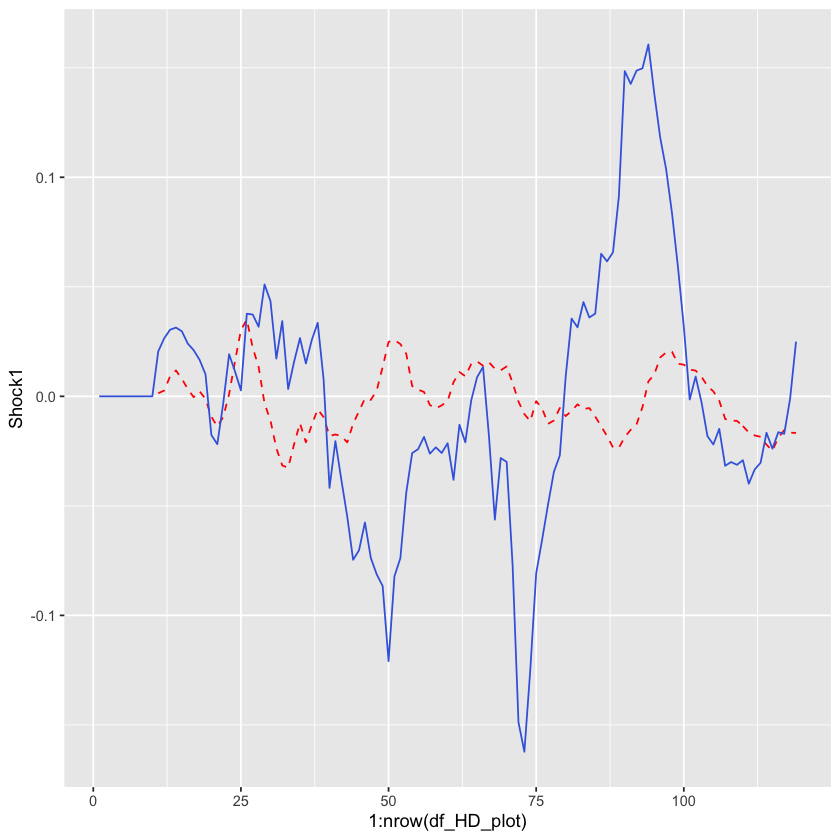

In [75]:
df_HD_plot <- bind_cols((By-SVAR_AB_Hist.c0)[,5],
                        (SVAR_AB_HistDecomp[,c(1,6,11,16,21)])[,5])
colnames(df_HD_plot) <- c("BaseLine", "Shock1")
ggplot(df_HD_plot)+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = Shock1), col = 'red', linetype = "dashed")+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = BaseLine), col = 'royalblue')

### 對「房價」的歷史分解：expectation shock對房價的解釋力

New names:
* NA -> ...1
* NA -> ...2



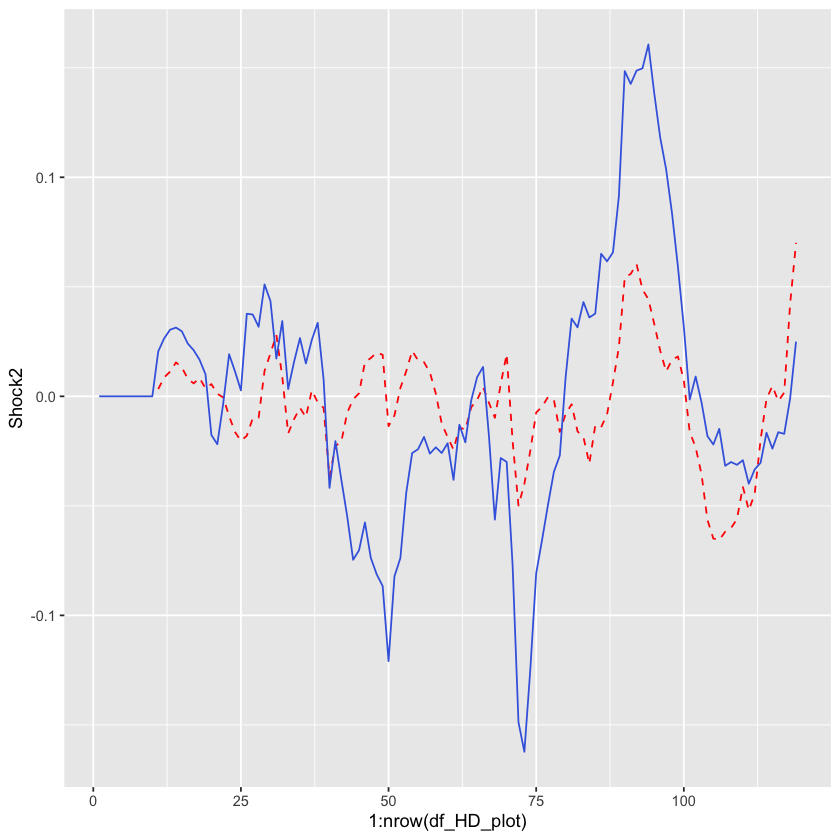

In [76]:
df_HD_plot <- bind_cols((By-SVAR_AB_Hist.c0)[,5],
                        (SVAR_AB_HistDecomp[,c(2,7,12,17,22)])[,5])
colnames(df_HD_plot) <- c("BaseLine", "Shock2")
ggplot(df_HD_plot)+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = Shock2), col = 'red', linetype = "dashed")+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = BaseLine), col = 'royalblue')

### 對「房價」的歷史分解：supply shock對房價的解釋力

New names:
* NA -> ...1
* NA -> ...2



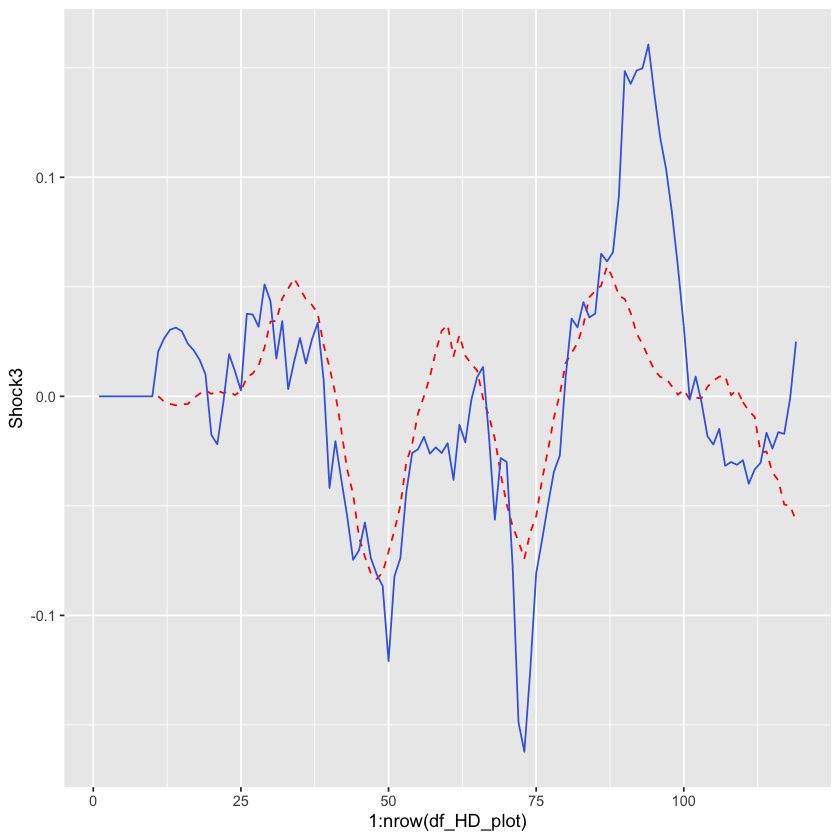

In [77]:
df_HD_plot <- bind_cols((By-SVAR_AB_Hist.c0)[,5],
                        (SVAR_AB_HistDecomp[,c(3,8,13,18,23)])[,5])
colnames(df_HD_plot) <- c("BaseLine", "Shock3")
ggplot(df_HD_plot)+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = Shock3), col = 'red', linetype = "dashed")+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = BaseLine), col = 'royalblue')

### 對「房價」的歷史分解：housing demand shock對房價的解釋力

New names:
* NA -> ...1
* NA -> ...2



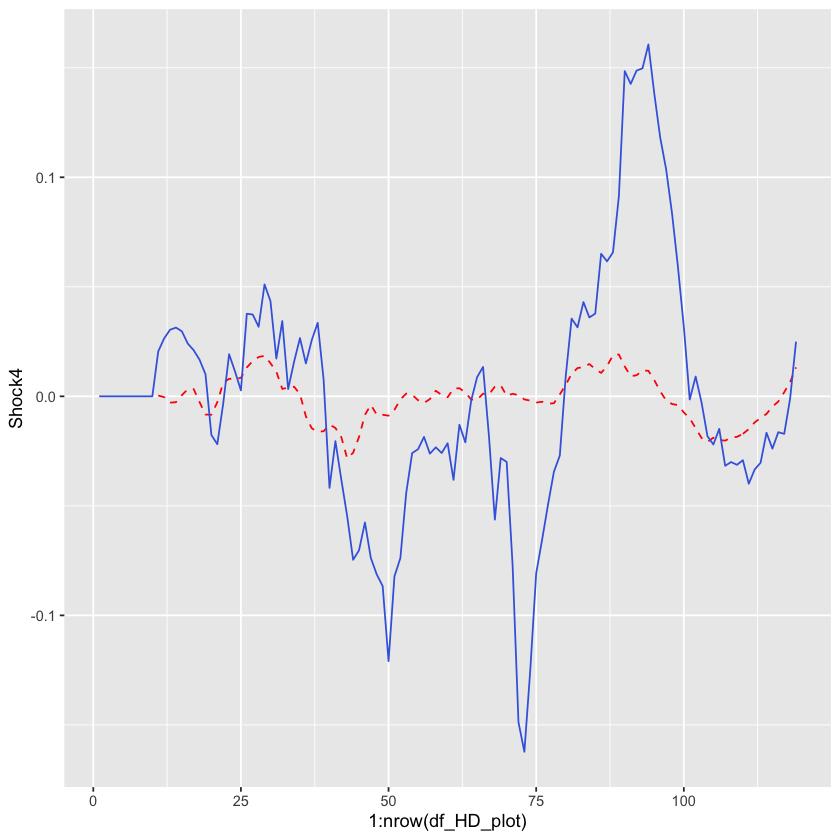

In [78]:
df_HD_plot <- bind_cols((By-SVAR_AB_Hist.c0)[,5],
                        (SVAR_AB_HistDecomp[,c(4,9,14,19,24)])[,5])
colnames(df_HD_plot) <- c("BaseLine", "Shock4")
ggplot(df_HD_plot)+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = Shock4), col = 'red', linetype = "dashed")+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = BaseLine), col = 'royalblue')

### 對「房價」的歷史分解：Residual shock對房價的解釋力

New names:
* NA -> ...1
* NA -> ...2



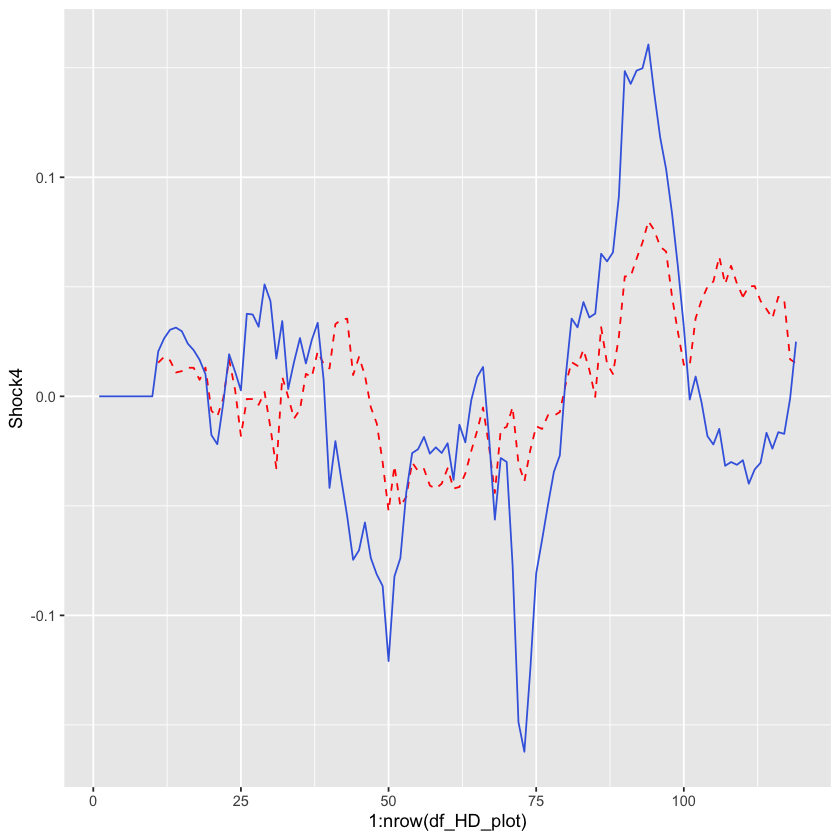

In [79]:
df_HD_plot <- bind_cols((By-SVAR_AB_Hist.c0)[,5],
                        (SVAR_AB_HistDecomp[,c(5,10,15,20,25)])[,5])
colnames(df_HD_plot) <- c("BaseLine", "Shock4")
ggplot(df_HD_plot)+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = Shock4), col = 'red', linetype = "dashed")+
  geom_line(aes(x = 1:nrow(df_HD_plot), y = BaseLine), col = 'royalblue')

### Table

* 為何從1992Q1開始？

    原始資料是1991Q1-2020Q3, 經過差分diff(x, 4)之後，會損失一年份（四季）的資料，所以變成從1992Q1開始

In [86]:
t_label <- c()
year_label <- c()
season_label <- c()
year <- 1991
for(q in 1:119){
    if(q%%4==0){
        t_label <- c(t_label, paste0(year, "Q4", sep = ""))
        year_label <- c(year_label, year)
        season_label <- c(season_label, 4)
        year <- year+1
    }else{
        t_label <- c(t_label, paste0(year, "Q", q%%4, sep = ""))
        year_label <- c(year_label, year)
        season_label <- c(season_label, q%%4)
    }
}

In [87]:
df_HD <- bind_cols(t_label,
                   year_label,
                   season_label,
                   (By-SVAR_AB_Hist.c0)[,5],
                   SVAR_AB_HistDecomp[,21],
                   SVAR_AB_HistDecomp[,22],
                   SVAR_AB_HistDecomp[,23],
                   SVAR_AB_HistDecomp[,24],
                   SVAR_AB_HistDecomp[,25])
colnames(df_HD) <- c("Time", "Year", "Season", "BaseLine", "mp", "exp", "hs", "hd", "sp")
tail(df_HD)

New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3
* NA -> ...4
* NA -> ...5
* ...



Time   Year Season BaseLine     mp          exp          hs         
1 2019Q2 2019 2      -0.016629681 -0.02205637 -0.001173033 -0.02517822
2 2019Q3 2019 3      -0.023887514 -0.02482443  0.004711025 -0.03471075
3 2019Q4 2019 4      -0.016362788 -0.01882948 -0.002182222 -0.03840865
4 2020Q1 2020 1      -0.017135680 -0.01543255  0.001711341 -0.04935896
5 2020Q2 2020 2      -0.001019538 -0.01659972  0.042169990 -0.04996692
6 2020Q3 2020 3       0.024968876 -0.01670922  0.070082558 -0.05669092
  hd           sp        
1 -0.008010487 0.03978486
2 -0.004724564 0.03565763
3 -0.002369586 0.04542358
4  0.001864172 0.04407673
5  0.006472641 0.01690088
6  0.013217454 0.01506540

In [88]:
df_HD.table <- df_HD %>% summarise(Time = Time,
                    Year = Year,
                    Season = Season,
                    mp = mp/BaseLine*100,
                    exp = exp/BaseLine*100,
                    hs = hs/BaseLine*100,
                    hd = hd/BaseLine*100,
                    sp = sp/BaseLine*100) %>%
    drop_na()

In [89]:
df_HD.table

Time   Year Season mp          exp          hs           hd         
1   1993Q3 1993 3         6.915032   16.163537     0.2063221    1.861204
2   1993Q4 1993 4         9.910322   32.573261    -9.2950559   -1.413801
3   1994Q1 1994 1        29.901791   37.037040   -11.4216668   -9.505839
4   1994Q2 1994 2        37.672525   49.287484   -13.0672359   -8.529729
5   1994Q3 1994 3        26.799747   44.529079   -12.0110635    1.911725
6   1994Q4 1994 4        13.942132   33.253270   -14.6894419   13.256453
7   1995Q1 1995 1        -1.758553   28.024114    -3.7872871   15.671992
8   1995Q2 1995 2        13.763961   50.088399     6.9352976  -15.929664
9   1995Q3 1995 3       -11.249524   35.650097    27.7132682  -82.580362
10  1995Q4 1995 4        52.912081  -31.564160    -6.1173409   47.524957
11  1996Q1 1996 1        62.882960   -5.330767   -12.0540227   12.289796
12  1996Q2 1996 2       282.963856   14.203389   -45.2251322 -183.327689
13  1996Q3 1996 3         5.243867  -47.020190    12.0779073   41.788205
14  1996Q4 1996 4       141.590868 -143.668930     5.1510105   68.756343
15  1997Q1 1997 1      1123.136209 -754.284062    88.4355086  314.070789
16  1997Q2 1997 2        92.993869  -47.705082    22.8894951   35.023088
17  1997Q3 1997 3        59.553999  -26.998127    27.8780115   42.983827
18  1997Q4 1997 4        42.142963  -30.719916    44.2406618   56.523278
19  1998Q1 1998 1        -6.418658   22.715026    43.6158455   36.203493
20  1998Q2 1998 2       -25.259732   45.064138    78.3402957   34.803652
21  1998Q3 1998 3      -137.512027  162.766323   200.2004522   65.268700
22  1998Q4 1998 4       -91.905403   26.162031   130.1211585    9.857991
23  1999Q1 1999 1      -979.431174 -508.415380  1475.7163674  119.666945
24  1999Q2 1999 2      -138.957870  -65.966121   341.3897250   27.903616
25  1999Q3 1999 3       -46.092672  -19.772615   184.8226890    3.716989
26  1999Q4 1999 4      -139.909633  -63.313424   295.6262032  -60.844835
27  2000Q1 2000 1       -50.498251   10.495824   162.6241907  -56.804777
28  2000Q2 2000 2       -17.557868   -8.116320   112.9244376  -48.167168
29  2000Q3 2000 3      -123.460943  -68.257269   306.1285800 -207.044198
30  2000Q4 2000 4        43.244811   88.151788   -31.7751772   30.816137
⋮   ⋮      ⋮    ⋮      ⋮           ⋮            ⋮            ⋮          
80  2013Q2 2013 2       -12.526943    36.560018   29.921036     9.161003
81  2013Q3 2013 3       -10.721313    39.172924   26.692583     6.441245
82  2013Q4 2013 4        -8.602166    40.568963   19.299272     6.467299
83  2014Q1 2014 1        -3.274273    32.549011   15.955231     7.888893
84  2014Q2 2014 2         4.242235    27.609300   11.097070     7.264003
85  2014Q3 2014 3         7.263002    23.862183    8.657982     5.344198
86  2014Q4 2014 4        14.990691    17.637758    7.533478     1.966110
87  2015Q1 2015 1        19.316405    10.944232    7.825435    -1.811175
88  2015Q2 2015 2        24.350427    19.953710    5.410999    -4.200886
89  2015Q3 2015 3        25.095559    30.756237    1.278044    -6.740050
90  2015Q4 2015 4        45.626554    22.783970    9.287502   -23.171170
91  2016Q1 2016 1      -837.355720  1119.144856   97.726838   689.460180
92  2016Q2 2016 2       130.146354  -257.220444   -7.313780  -160.560183
93  2016Q3 2016 3      -322.954641  1291.305721   33.192965   688.647433
94  2016Q4 2016 4       -25.902161   310.326360  -23.746271   114.461799
95  2017Q1 2017 1       -10.301950   295.351195  -32.732328    86.034986
96  2017Q2 2017 2        13.607118   441.075035  -60.272214   134.271454
97  2017Q3 2017 3        32.594468   194.984080  -29.577328    63.735844
98  2017Q4 2017 4        37.083510   200.439018   -1.771414    62.932253
99  2018Q1 2018 1        35.821879   179.254354   -9.597393    59.177020
100 2018Q2 2018 2        46.579494   141.445743    8.963085    58.795044
101 2018Q3 2018 3        41.283073   130.275391   16.674356    37.523651
102 2018Q4 2018 4        53.531525   133.518140   28.125866   

In [90]:
get_HD.table <- function(df_HD.table, 
                         year_start, season_start,
                         year_end, season_end){
    HD_seq.temp <- df_HD.table %>%
        filter( Year >= year_start & Year <= year_end) %>%
        filter( !(Year==year_start & Season < season_start) ) %>%
        filter( !(Year==year_end & Season > season_end) ) %>%
        summarise(mp = median(mp),
          exp = median(exp),
          hs = median(hs),
          hd = median(hd),
          sp = median(sp))
    return(HD_seq.temp)
}

In [91]:
# all samples
# 全樣本期間：1991Q1-2020Q3
HD_seq1 <- get_HD.table(df_HD.table, 1991, 1, 2020, 3)

# subsample 1: 1991Q1-2003Q3 (持平)
HD_seq2 <- get_HD.table(df_HD.table, 1991, 1, 2003, 3)

# subsample 2: 2003Q3-2006Q4 (上漲)
HD_seq3 <- get_HD.table(df_HD.table, 2003, 3, 2006, 4)

# subsample 3: 2006Q4-2009Q2 (下跌)
HD_seq4 <- get_HD.table(df_HD.table, 2006, 4, 2009, 2)

# subsample 4: 2009Q2-2013Q3 (上漲)
HD_seq5 <- get_HD.table(df_HD.table, 2009, 2, 2013, 3)

# subsample 5: 2013Q3-2016Q2 (下跌)
HD_seq6 <- get_HD.table(df_HD.table, 2013, 3, 2016, 2)

# subsample 6: 2016Q2-2020Q3 (上漲)
HD_seq7 <- get_HD.table(df_HD.table, 2016, 2, 2020, 3)

In [92]:
HD_seq <- bind_rows(HD_seq1, HD_seq2, HD_seq3, HD_seq4, HD_seq5, HD_seq6, HD_seq7)
HD.table <- bind_cols(c("All Samples (1993Q4-2020Q3)",
                        "Subsample 1 (1993Q4-2003Q3)",
                        "Subsample 2 (2003Q3-2006Q4)",
                        "Subsample 3 (2006Q4-2009Q2)",
                        "Subsample 4 (2009Q2-2013Q3)",
                        "Subsample 5 (2013Q3-2016Q2)",
                        "Subsample 6 (2016Q2-2020Q3)"), HD_seq)
colnames(HD.table) <- c("樣本期間", 
                        "Montary Policy Shock", 
                        "Expectation Shock",
                        "Demand Shock",
                        "Supply Shock",
                        "Residual Shock")
HD.table

New names:
* NA -> ...1



樣本期間                    Montary Policy Shock Expectation Shock
1 All Samples (1993Q4-2020Q3)   4.242235            14.203389       
2 Subsample 1 (1993Q4-2003Q3)   6.915032            10.495824       
3 Subsample 2 (2003Q3-2006Q4) -17.509373             2.733689       
4 Subsample 3 (2006Q4-2009Q2)  -8.114771            19.939250       
5 Subsample 4 (2009Q2-2013Q3) -12.968760             2.740869       
6 Subsample 5 (2013Q3-2016Q2)  11.126847            25.735742       
7 Subsample 6 (2016Q2-2020Q3)  43.931283           137.481941       
  Demand Shock Supply Shock Residual Shock
1  34.482061    9.1321876     33.71687    
2  44.240662   13.2564532     28.17126    
3 -40.941204   -0.1772405    153.73211    
4  49.728466   -0.8429323     23.92723    
5  62.811136   18.6977926     28.20165    
6   8.972742    3.6551538     49.69444    
7  12.818721   50.5527682   -181.65790

In [93]:
# 生出table
tab_HD <- xtable(HD.table, caption= "歷史分解下各衝擊的解釋力比率(%)", align=c("c","c","c","c","c","c", "c"))
print(tab_HD, include.rownames=FALSE)

% latex table generated in R 4.1.2 by xtable 1.8-4 package
% Mon Nov  8 21:21:52 2021
\begin{table}[ht]
\centering
\begin{tabular}{cccccc}
  \hline
樣本期間 & Montary Policy Shock & Expectation Shock & Demand Shock & Supply Shock & Residual Shock \\ 
  \hline
All Samples (1993Q4-2020Q3) & 4.24 & 14.20 & 34.48 & 9.13 & 33.72 \\ 
  Subsample 1 (1993Q4-2003Q3) & 6.92 & 10.50 & 44.24 & 13.26 & 28.17 \\ 
  Subsample 2 (2003Q3-2006Q4) & -17.51 & 2.73 & -40.94 & -0.18 & 153.73 \\ 
  Subsample 3 (2006Q4-2009Q2) & -8.11 & 19.94 & 49.73 & -0.84 & 23.93 \\ 
  Subsample 4 (2009Q2-2013Q3) & -12.97 & 2.74 & 62.81 & 18.70 & 28.20 \\ 
  Subsample 5 (2013Q3-2016Q2) & 11.13 & 25.74 & 8.97 & 3.66 & 49.69 \\ 
  Subsample 6 (2016Q2-2020Q3) & 43.93 & 137.48 & 12.82 & 50.55 & -181.66 \\ 
   \hline
\end{tabular}
\caption{歷史分解下各衝擊的解釋力比率(%)} 
\end{table}


In [94]:
print(tab_HD, include.rownames=FALSE,
      file="result/table/HD_0219_m1.tex",
      append=T, table.placement = "h",
      caption.placement="bottom", hline.after=seq(from=-1,to=nrow(tab_HD),by=1))

### Save Plot

In [95]:
xlab <- lubridate::yq(df_HD$Time)

In [96]:
# plot 1
figure_HD.1 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = mp, color = "Monetary Policy Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = BaseLine, color = "dLHP Deviations from Base Projection"))+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of dLhp: Monetary Policy Shock')+
    Text_Size_Theme+
    scale_color_manual(values=c('royalblue','red'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())

# plot 2
figure_HD.2 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = exp, color = "Housing Expectation Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = BaseLine, color = "dLHP Deviations from Base Projection"))+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of dLhp: Housing Expectation Shock')+
    Text_Size_Theme+
    scale_color_manual(values=c('royalblue','red'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())

# plot 3
figure_HD.3 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = hs, color = "Housing Supply Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = BaseLine, color = "dLHP Deviations from Base Projection"))+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of dLhp: Housing Supply Shock')+
    Text_Size_Theme+
    scale_color_manual(values=c('royalblue','red'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())

# plot 4
figure_HD.4 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = hd, color = "Housing Demand Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = BaseLine, color = "dLHP Deviations from Base Projection"))+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of dLhp: Housing Demand Shock')+
    Text_Size_Theme+
    scale_color_manual(values=c('royalblue','red'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())



# plot 5
figure_HD.5 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = sp, color = "Residual Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = BaseLine, color = "dLHP Deviations from Base Projection"))+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of dLhp: Residual Shock')+
    Text_Size_Theme+
    scale_color_manual(values=c('royalblue','red'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())

In [97]:
# save shock 1
ggsave(filename = "result/figure/0219_m1_HD_shock1.png", 
       plot = figure_HD.1,
       width = 15, height = 10, units = "cm",
       device = "png")

# save shock 2
ggsave(filename = "result/figure/0219_m1_HD_shock2.png", 
       plot = figure_HD.2,
       width = 15, height = 10, units = "cm",
       device = "png")

# save shock 3
ggsave(filename = "result/figure/0219_m1_HD_shock3.png", 
       plot = figure_HD.3,
       width = 15, height = 10, units = "cm",
       device = "png")

# save shock 4
ggsave(filename = "result/figure/0219_m1_HD_shock4.png", 
       plot = figure_HD.4,
       width = 15, height = 10, units = "cm",
       device = "png")
# save shock 5
ggsave(filename = "result/figure/0219_m1_HD_shock5.png", 
       plot = figure_HD.5,
       width = 15, height = 10, units = "cm",
       device = "png")

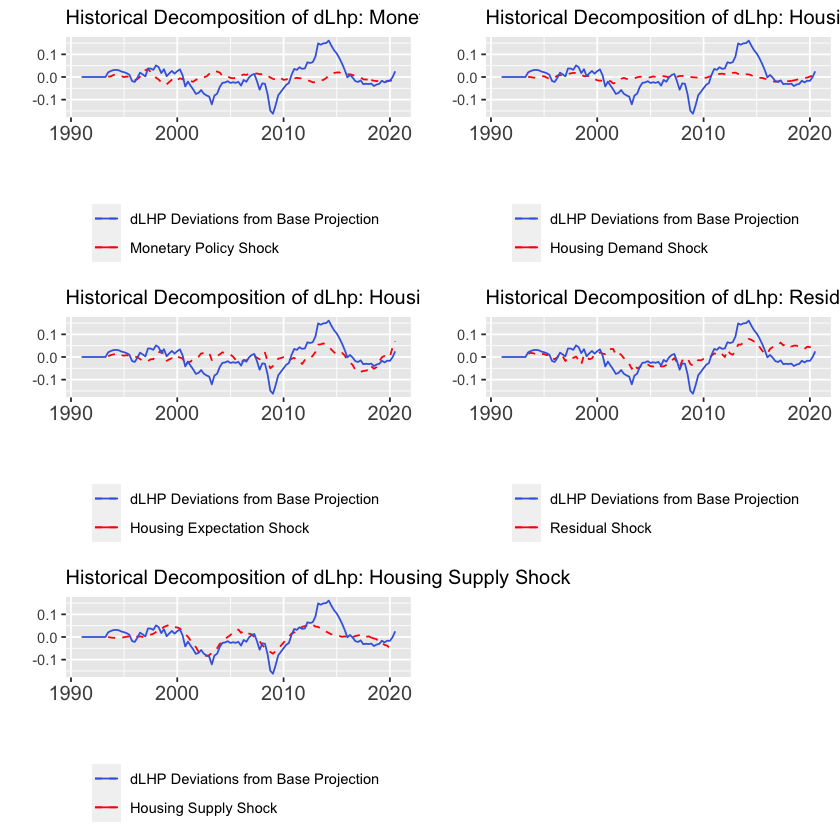

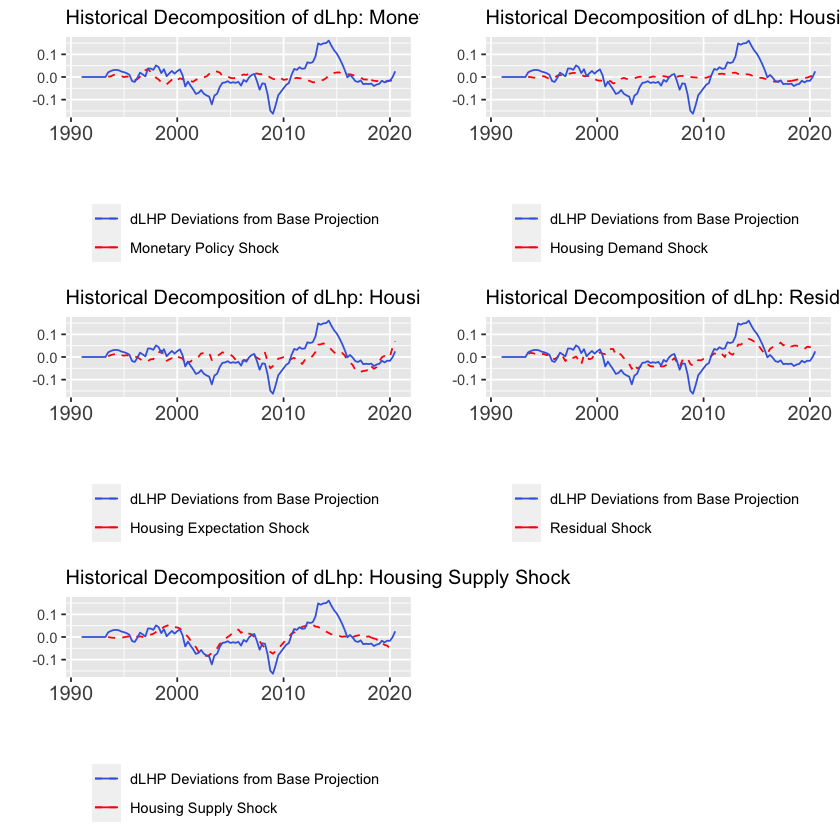

In [98]:
# For hp
multiplot(figure_HD.1,figure_HD.2,figure_HD.3,figure_HD.4,figure_HD.5,
          cols = 2)
ggsave(filename = "result/figure/HD.png", 
       plot = multiplot(figure_HD.1,
                        figure_HD.2,
                        figure_HD.3,
                        figure_HD.4,
                        figure_HD.5,
                        cols = 2),
       width = 15*2, height = 10*2, units = "cm",
       device = "png")

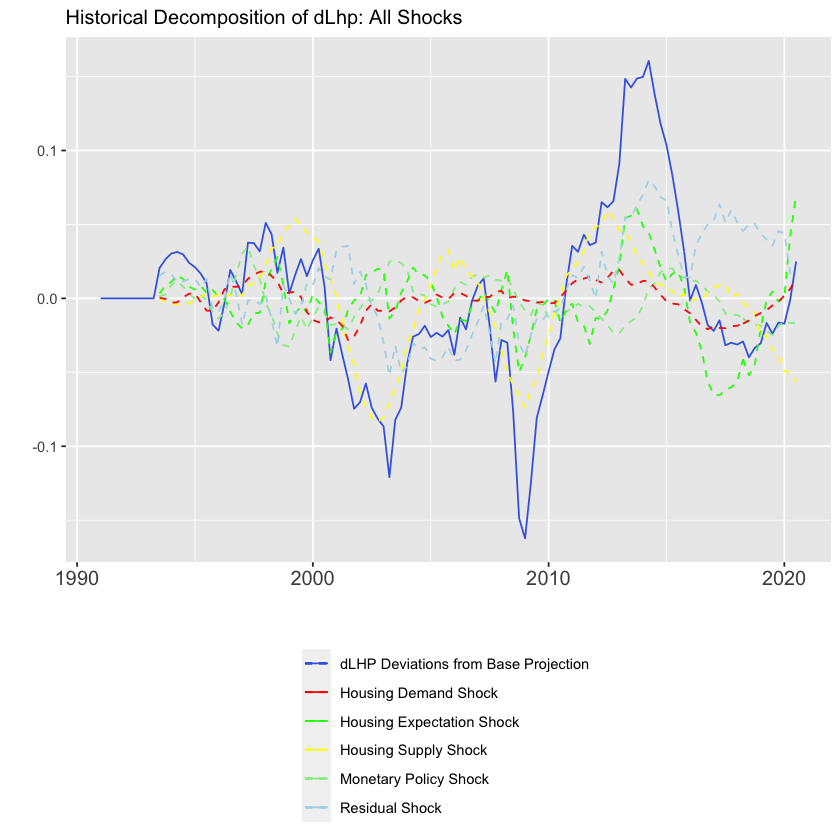

In [99]:
# ALL
figure_HD.6 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = BaseLine, color = "dLHP Deviations from Base Projection"))+
    geom_line(aes(x = xlab, y = mp, color = "Monetary Policy Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = exp, color = "Housing Expectation Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = hs, color = "Housing Supply Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = hd, color = "Housing Demand Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = sp, color = "Residual Shock"), linetype = "dashed")+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of dLhp: All Shocks')+
    Text_Size_Theme+
    scale_color_manual(values=c('royalblue','red', 'green', 'yellow', 'lightgreen', 'lightblue'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())
# save shock 6
ggsave(filename = "result/figure/0219_m1_HD_shock6.png", 
       plot = figure_HD.6,
       width = 15, height = 10, units = "cm",
       device = "png")
figure_HD.6

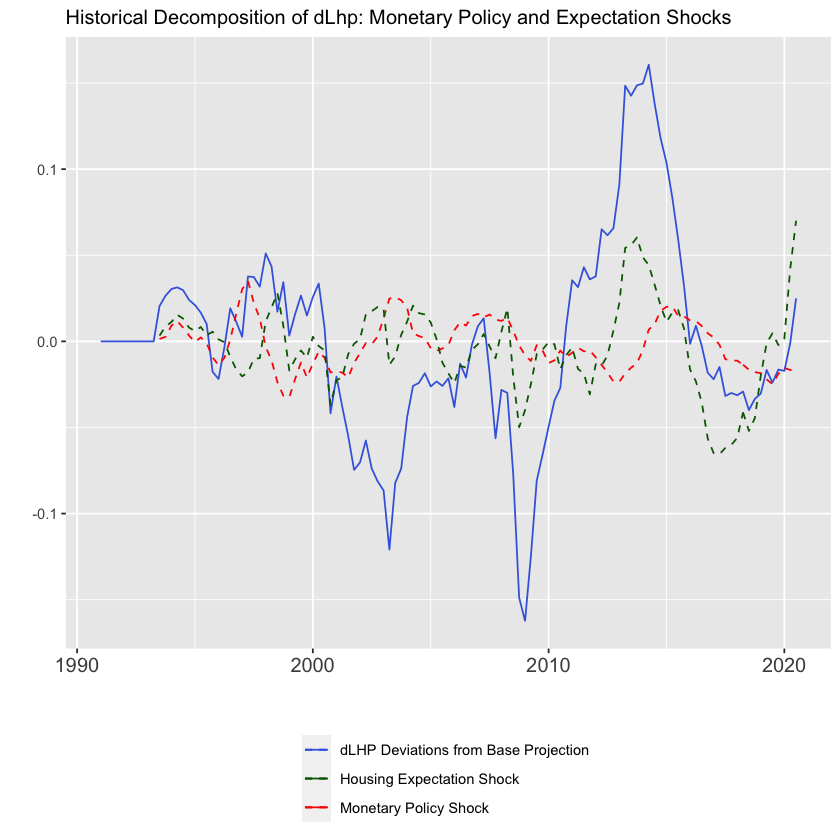

In [100]:
# ALL
figure_HD.6 <- df_HD %>%
    ggplot()+
    geom_line(aes(x = xlab, y = BaseLine, color = "dLHP Deviations from Base Projection"))+
    geom_line(aes(x = xlab, y = mp, color = "Monetary Policy Shock"), linetype = "dashed")+
    geom_line(aes(x = xlab, y = exp, color = "Housing Expectation Shock"), linetype = "dashed")+
#     geom_line(aes(x = xlab, y = sp, color = "Residual Shock"), linetype = "dashed")+
    labs(x = '',
         y = '',
         title = 'Historical Decomposition of dLhp: Monetary Policy and Expectation Shocks')+
    Text_Size_Theme+
    scale_color_manual(values=c('royalblue', 'darkgreen', 'red'))+
    theme(legend.position="bottom", 
          legend.direction="vertical",
          legend.title = element_blank())
# save shock 6
ggsave(filename = "result/figure/0219_m1_HD_shock6.png", 
       plot = figure_HD.6,
       width = 20, height = 15, units = "cm",
       device = "png")
figure_HD.6

In [101]:
getwd()

[1] "/Users/boyie/Documents/Thesis/codes & TeX/model/0_new_benchmark_lag"